In [1]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

green = '#69f900'
orange = '#ffa500'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
col1 = '#00a0de'
col2 = '#ffa500'

In [13]:
# Put Match HTML File path here
match_html_path = r"/Users/hazanserifli/Desktop/yazılım/futbol/dashboards/new/Manchester City 2-3 Real Madrid - Champions League 2024:2025 Live.html"
# Put the Fotmob matchId here
fotmob_matchId = 4723900

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_df['name'] = players_df['name'].astype(str)
    players_df['name'] = players_df['name'].apply(unidecode)
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    
    return events_dict, players_df, teams_dict

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

# Extract the 'displayName' value
df['type'] = df['type'].astype(str)
df['outcomeType'] = df['outcomeType'].astype(str)
df['period'] = df['period'].astype(str)
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4, 
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})

def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=100, min_carry_duration=1, max_carry_duration=50):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 100.0
    min_carry_duration = 1.0
    max_carry_duration = 50.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_events.loc[match_events['type'] == 'BallRecovery', 'endX'] = match_events.loc[match_events['type'] == 'BallRecovery', 'endX'].fillna(match_events['x'])
    match_events.loc[match_events['type'] == 'BallRecovery', 'endY'] = match_events.loc[match_events['type'] == 'BallRecovery', 'endY'].fillna(match_events['y'])
    match_carries = pd.DataFrame()
    
    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')
                      or (next_evt['type'] == 'Card')
                     ):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=100, min_carry_duration=1, max_carry_duration=50)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


# xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None)
xT = pd.read_csv(r"/Users/hazanserifli/Desktop/yazılım/futbol/dashboards/new/xT_Grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'outcomeType', 'qualifiers',  'type',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot', 'cumulative_mins']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)
df = df.merge(dfp, on='playerId', how='left')

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'), 
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'), 
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

df['name'] = df['name'].astype(str)
df['name'] = df['name'].apply(unidecode)
# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['name'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['id']
df.drop(columns=columns_to_drop2, inplace=True)

def get_possession_chains(events_df, chain_check, suc_evts_in_chain):
    # Initialise output
    events_out = pd.DataFrame()
    match_events_df = df.reset_index()

    # Isolate valid event types that contribute to possession
    match_pos_events_df = match_events_df[~match_events_df['type'].isin(['OffsideGiven', 'CornerAwarded','Start', 'Card', 'SubstitutionOff',
                                                                                  'SubstitutionOn', 'FormationChange','FormationSet', 'End'])].copy()

    # Add temporary binary outcome and team identifiers
    match_pos_events_df['outcomeBinary'] = (match_pos_events_df['outcomeType']
                                                .apply(lambda x: 1 if x == 'Successful' else 0))
    match_pos_events_df['teamBinary'] = (match_pos_events_df['teamName']
                         .apply(lambda x: 1 if x == min(match_pos_events_df['teamName']) else 0))
    match_pos_events_df['goalBinary'] = ((match_pos_events_df['type'] == 'Goal')
                         .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))

    # Create a dataframe to investigate possessions chains
    pos_chain_df = pd.DataFrame()

    # Check whether each event is completed by same team as the next (check_evts-1) events
    for n in np.arange(1, chain_check):
        pos_chain_df[f'evt_{n}_same_team'] = abs(match_pos_events_df['teamBinary'].diff(periods=-n))
        pos_chain_df[f'evt_{n}_same_team'] = pos_chain_df[f'evt_{n}_same_team'].apply(lambda x: 1 if x > 1 else x)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df.sum(axis=1).apply(lambda x: 1 if x < chain_check - suc_evts_in_chain else 0)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df['enough_evt_same_team'].diff(periods=1)
    pos_chain_df[pos_chain_df['enough_evt_same_team'] < 0] = 0

    match_pos_events_df['period'] = pd.to_numeric(match_pos_events_df['period'], errors='coerce')
    # Check there are no kick-offs in the upcoming (check_evts-1) events
    pos_chain_df['upcoming_ko'] = 0
    for ko in match_pos_events_df[(match_pos_events_df['goalBinary'] == 1) | (match_pos_events_df['period'].diff(periods=1))].index.values:
        ko_pos = match_pos_events_df.index.to_list().index(ko)
        pos_chain_df.iloc[ko_pos - suc_evts_in_chain:ko_pos, 5] = 1

    # Determine valid possession starts based on event team and upcoming kick-offs
    pos_chain_df['valid_pos_start'] = (pos_chain_df.fillna(0)['enough_evt_same_team'] - pos_chain_df.fillna(0)['upcoming_ko'])

    # Add in possession starts due to kick-offs (period changes and goals).
    pos_chain_df['kick_off_period_change'] = match_pos_events_df['period'].diff(periods=1)
    pos_chain_df['kick_off_goal'] = ((match_pos_events_df['type'] == 'Goal')
                     .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))
    pos_chain_df.loc[pos_chain_df['kick_off_period_change'] == 1, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df['kick_off_goal'] == 1, 'valid_pos_start'] = 1

    # Add first possession manually
    pos_chain_df['teamName'] = match_pos_events_df['teamName']
    pos_chain_df.loc[pos_chain_df.head(1).index, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_id'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_team'] = pos_chain_df.loc[pos_chain_df.head(1).index, 'teamName']

    # Iterate through valid possession starts and assign them possession ids
    valid_pos_start_id = pos_chain_df[pos_chain_df['valid_pos_start'] > 0].index

    possession_id = 2
    for idx in np.arange(1, len(valid_pos_start_id)):
        current_team = pos_chain_df.loc[valid_pos_start_id[idx], 'teamName']
        previous_team = pos_chain_df.loc[valid_pos_start_id[idx - 1], 'teamName']
        if ((previous_team == current_team) & (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_goal'] != 1) &
                (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_period_change'] != 1)):
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = np.nan
        else:
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = possession_id
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_team'] = pos_chain_df.loc[valid_pos_start_id[idx], 'teamName']
            possession_id += 1

    # Assign possession id and team back to events dataframe
    match_events_df = pd.merge(match_events_df, pos_chain_df[['possession_id', 'possession_team']], how='left', left_index=True, right_index=True)

    # Fill in possession ids and possession team
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='ffill'))
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='bfill'))

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_df])

    return events_out

df = get_possession_chains(df, 5, 3)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime', 
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

df = df[df['period']!='PenaltyShootout']
df = df.reset_index(drop=True)

hteamID = list(teams_dict.keys())[0]  # selected home team
ateamID = list(teams_dict.keys())[1]  # selected away team
hteamName= teams_dict[hteamID]
ateamName= teams_dict[ateamID]

def scrape_shots(mi):
    headers = {
    'sec-ch-ua-platform': '"Windows"',
    'Referer': 'https://www.fotmob.com/en-GB/matches/manchester-city-vs-real-madrid/2ey0nu',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    'x-mas': 'eyJib2R5Ijp7InVybCI6Ii9hcGkvbWF0Y2hEZXRhaWxzP21hdGNoSWQ9NDUwNjkxNiZzaG93TmV3VWVmYUJyYWNrZXQ9dHJ1ZSIsImNvZGUiOjE3MzQzMjY5NDYwMTgsImZvbyI6ImI1ZWY3NzhlYiJ9LCJzaWduYXR1cmUiOiJGQjRDMEUyOTU0OTUyODMyNzE3ODhFRDE4RTNDRjc2OCJ9',
    'sec-ch-ua': '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
    'sec-ch-ua-mobile': '?0',} # This headers changes regularly, so you need to get the new header everytime Fotmob change it.

    params = {
    'matchId': mi,
    'showNewUefaBracket': 'true'}

    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params, headers=headers)
    data = response.json()
    shotmap = data['content']['shotmap']['shots']
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi

    return shots_df

df_teamNameId = pd.read_csv(r"/Users/hazanserifli/Desktop/yazılım/futbol/dashboards/new/teams_name_and_id.csv")

shots_df = scrape_shots(fotmob_matchId)
shots_df = shots_df.merge(df_teamNameId[['teamId', 'teamName']], on='teamId', how='left')

def get_opposite_teamName(team):
    if team == hteamName:
        return ateamName
    elif team == ateamName:
        return hteamName
    else:
        return None
# Apply the function to create the new column
shots_df['oppositeTeam'] = shots_df['teamName'].apply(get_opposite_teamName)
shots_df['playerName'] = shots_df['playerName'].astype(str)
shots_df['playerName'] = shots_df['playerName'].apply(unidecode)
shots_df = shots_df[shots_df['period']!='PenaltyShootout']
shots_df['expectedGoals'] = shots_df['expectedGoals'].fillna(0)
shots_df['expectedGoalsOnTarget'] = shots_df['expectedGoalsOnTarget'].fillna(0)

homedf = df[(df['teamName']==hteamName)]
awaydf = df[(df['teamName']==ateamName)]
hxT = homedf['xT'].sum().round(2)
axT = awaydf['xT'].sum().round(2)

hcol = col1
acol = col2

hgoal_count = len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))])
hgoal_count = hgoal_count + len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = agoal_count + len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))])

hshots_xgdf = shots_df[shots_df['teamName']==hteamName]
ashots_xgdf = shots_df[shots_df['teamName']==ateamName]
hxg = round(hshots_xgdf['expectedGoals'].sum(), 2)
axg = round(ashots_xgdf['expectedGoals'].sum(), 2)
hxgot = round(hshots_xgdf['expectedGoalsOnTarget'].sum(), 2)
axgot = round(ashots_xgdf['expectedGoalsOnTarget'].sum(), 2)

fotmob_hteam_id = df_teamNameId[df_teamNameId['teamName']==hteamName].teamId.to_list()[0]
fotmob_ateam_id = df_teamNameId[df_teamNameId['teamName']==ateamName].teamId.to_list()[0]

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2162/2734820065.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2162/2734820065.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2162/2734820065.py:344: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4223941635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "receiver"] = df["playerId"].shift(-1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4223941635.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4223941635.py:98: SettingWithCopyWarning: 
A value is trying

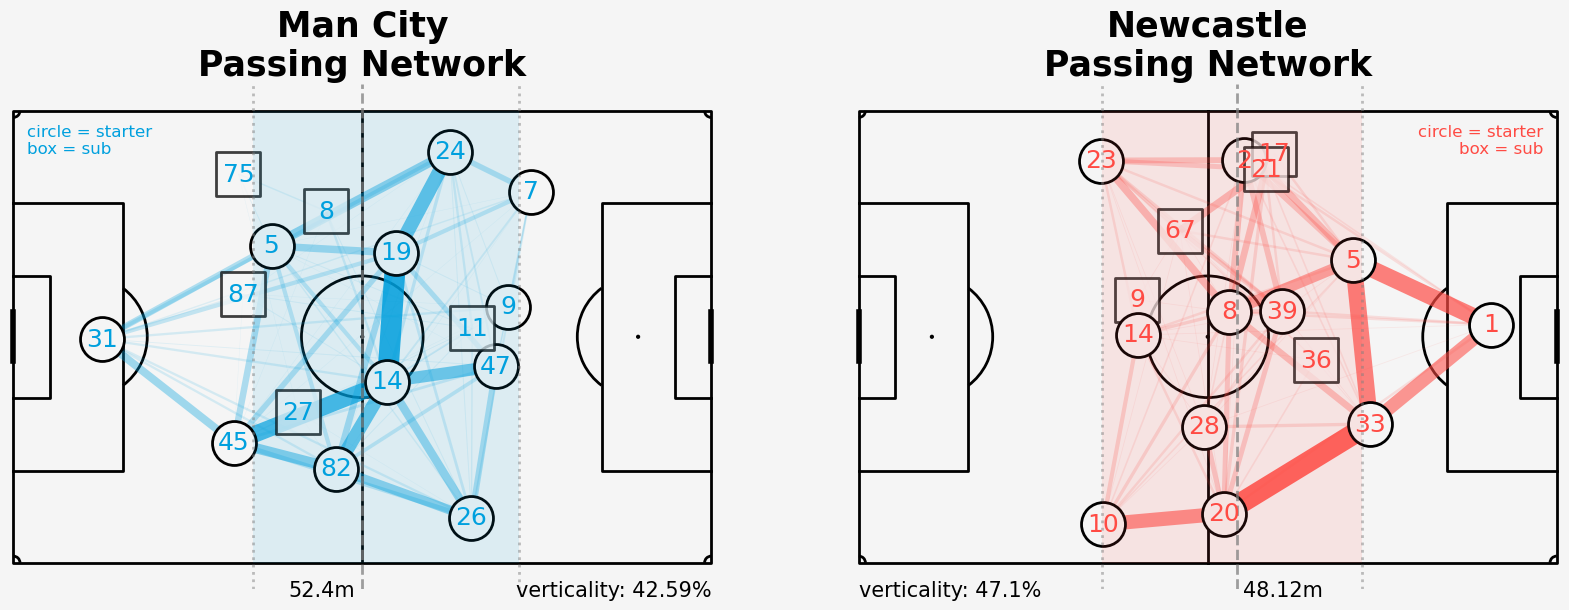

In [61]:
def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY", "teamName", "playerId", "receiver", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes

passes_df = get_passes_df(df)
path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def get_passes_between_df(teamName, passes_df, players_df):
    passes_df = passes_df[(passes_df["teamName"] == teamName)]
    # df = pd.DataFrame(events_dict)
    dfteam = df[(df['teamName'] == teamName) & (~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card'))]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    average_locs_and_count_df['name'] = average_locs_and_count_df['name'].apply(unidecode)
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['index', 'playerId', 'receiver', 'teamName']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).index.count().reset_index()
    passes_between_df.rename({'index': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

# home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(hteamName, passes_df, players_df)
# away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(ateamName, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, teamName, flipped=False):
    MAX_LINE_WIDTH = 15
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=bg_color, edgecolor=line_color, linewidth=2, alpha=1, ax=ax)
      else:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='s', color=bg_color, edgecolor=line_color, linewidth=2, alpha=0.75, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=18, ax=ax)

    # Plotting a vertical line to show the median vertical position of all passes
    avgph = round(average_locs_and_count_df['pass_avg_x'].median(), 2)
    # avgph_show = round((avgph*1.05),2)
    avgph_show = avgph
    ax.axvline(x=avgph, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Height
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['pass_avg_x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    # Forward line Height
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']==1]
    Forwards_height = Forwards_height.sort_values(by='pass_avg_x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['pass_avg_x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    # coloring the middle zone in the pitch
    ymid = [0, 0, 68, 68]
    xmid = [def_line_h, fwd_line_h, fwd_line_h, def_line_h]
    ax.fill(xmid, ymid, col, alpha=0.1)

    team_passes_df = passes_df[(passes_df["teamName"] == teamName)]
    team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
    team_passes_df = team_passes_df[(team_passes_df['pass_or_carry_angle']>=0) & (team_passes_df['pass_or_carry_angle']<=90)]
    
    med_ang = team_passes_df['pass_or_carry_angle'].median()
    verticality = round((1 - med_ang/90)*100, 2)

    passes_between_df = passes_between_df.sort_values(by='pass_count', ascending=False).head(1).reset_index(drop=True)
    most_pass_from = passes_between_df['name'][0]
    most_pass_to = passes_between_df['name_end'][0]
    most_pass_count = passes_between_df['pass_count'][0]
    

    if teamName == ateamName:
      # inverting the pitch for away team
      ax.invert_xaxis()
      ax.invert_yaxis()
      ax.text(avgph-1, 73, f"{avgph_show}m", fontsize=15, color=line_color, ha='left')
      ax.text(105, 73,f"verticality: {verticality}%", fontsize=15, color=line_color, ha='left')
    else:
      ax.text(avgph-1, -5, f"{avgph_show}m", fontsize=15, color=line_color, ha='right')
      ax.text(105, -5, f"verticality: {verticality}%", fontsize=15, color=line_color, ha='right')

    # Headlines and other texts
    if teamName == hteamName:
      ax.text(2,66, "circle = starter\nbox = sub", color=hcol, size=12, ha='left', va='top')
      ax.set_title(f"{hteamName}\nPassing Network", color=line_color, size=25, fontweight='bold')
      # ax.text(52.5, 75, f"{hteamName}\nPassing Network", color=line_color, size=35, ha='center', va='center', fontweight='bold', fontproperties=custom_font)

    else:
      ax.text(2,2, "circle = starter\nbox = sub", color=acol, size=12, ha='right', va='top')
      ax.set_title(f"{ateamName}\nPassing Network", color=line_color, size=25, fontweight='bold')

    return {
        'Team_Name': teamName,
        'Defense_Line_Height': def_line_h,
        'Vericality_%': verticality,
        'Most_pass_combination_from': most_pass_from,
        'Most_pass_combination_to': most_pass_to,
        'Most_passes_in_combination': most_pass_count,
    } 

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
pass_network_stats_home = pass_network_visualization(axs[0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
pass_network_stats_away = pass_network_visualization(axs[1], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)
pass_network_stats_list = []
pass_network_stats_list.append(pass_network_stats_home)
pass_network_stats_list.append(pass_network_stats_away)
pass_network_stats_df = pd.DataFrame(pass_network_stats_list)

In [62]:
pass_network_stats_df

Team_Name  Defense_Line_Height  Vericality_% Most_pass_combination_from  \
0   Man City                36.02         42.59             Ilkay Gundogan   
1  Newcastle                29.35         47.10                   Dan Burn   

  Most_pass_combination_to  Most_passes_in_combination  
0            Nico Gonzalez                          45  
1               Lewis Hall                          25

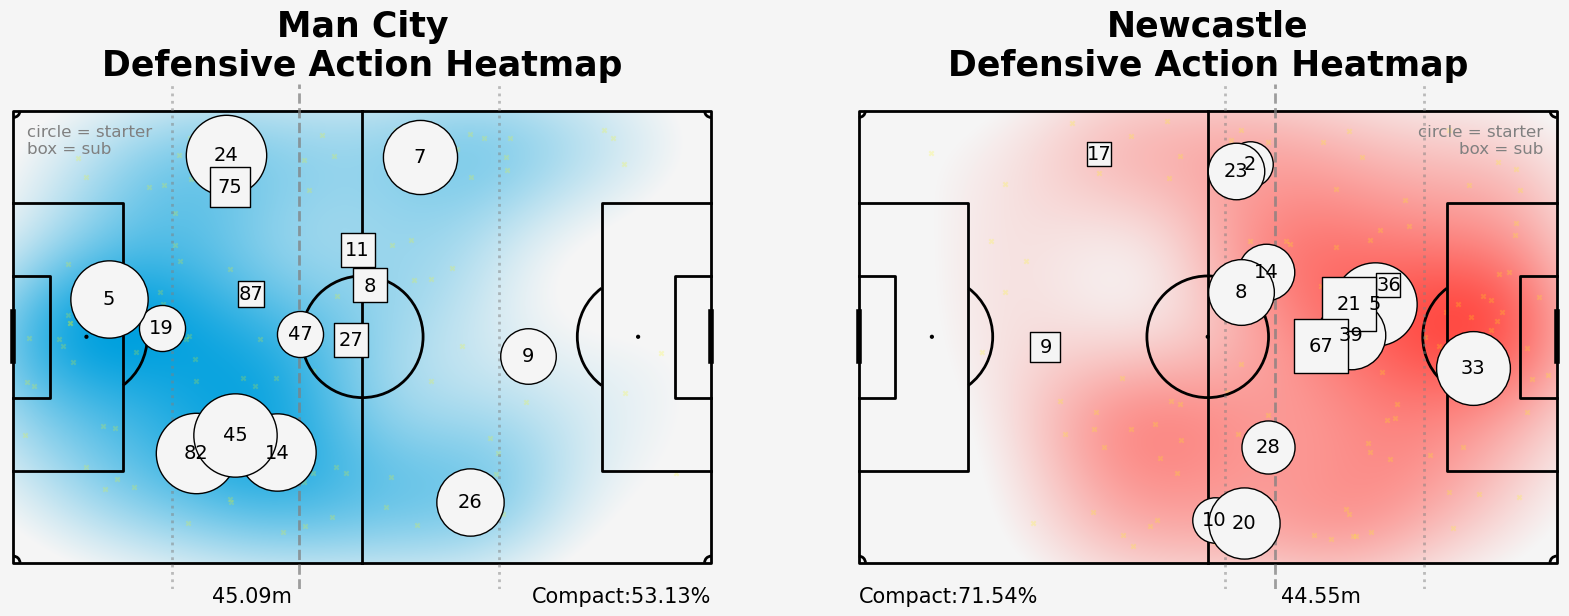

In [63]:
def get_defensive_action_df(events_dict):
    # filter only defensive actions
    defensive_actions_ids = df.index[(df['type'] == 'Aerial') & (df['qualifiers'].str.contains('Defensive')) |
                                     (df['type'] == 'BallRecovery') |
                                     (df['type'] == 'BlockedPass') |
                                     (df['type'] == 'Challenge') |
                                     (df['type'] == 'Clearance') |
                                     (df['type'] == 'Error') |
                                     (df['type'] == 'Foul') |
                                     (df['type'] == 'Interception') |
                                     (df['type'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["index", "x", "y", "teamName", "playerId", "type", "outcomeType"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def get_da_count_df(team_name, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(hteamName, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(ateamName, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position'] != 'GK']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position'] != 'GK']

def defensive_block(ax, average_locs_and_count_df, team_name, col):
    defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_facecolor(bg_color)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    # using variable marker size for each player according to their defensive engagements
    MAX_MARKER_SIZE = 3500
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    # plotting the heatmap of the team defensive actions
    color = np.array(to_rgba(col))
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [bg_color, col], N=500)
    kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

    # using different node marker for starting and substitute players
    average_locs_and_count_df = average_locs_and_count_df.reset_index(drop=True)
    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='o', color=bg_color, edgecolor=line_color, linewidth=1, 
                                 alpha=1, zorder=3, ax=ax)
        else:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='s', color=bg_color, edgecolor=line_color, linewidth=1, 
                                     alpha=1, zorder=3, ax=ax)
    # plotting very tiny scatterings for the defensive actions
    da_scatter = pitch.scatter(defensive_actions_team_df.x, defensive_actions_team_df.y, s=10, marker='x', color='yellow', alpha=0.2, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.x, row.y), c=line_color, ha='center', va='center', size=(14), ax=ax)

    # Plotting a vertical line to show the median vertical position of all defensive actions, which is called Defensive Actions Height
    dah = round(average_locs_and_count_df['x'].mean(), 2)
    dah_show = round((dah*1.05), 2)
    ax.axvline(x=dah, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Height
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    # Forward line Height
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']==1]
    Forwards_height = Forwards_height.sort_values(by='x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)

    compactness = round((1 - ((fwd_line_h - def_line_h) / 105)) * 100, 2)
    
    if team_name == ateamName:
        # inverting the axis for away team
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(dah-1, 73, f"{dah_show}m", fontsize=15, color=line_color, ha='left', va='center')
    else:
        ax.text(dah-1, -5, f"{dah_show}m", fontsize=15, color=line_color, ha='right', va='center')

    # Headlines and other texts
    if team_name == hteamName:
        ax.text(105, -5, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='right', va='center')
        ax.text(2,66, "circle = starter\nbox = sub", color='gray', size=12, ha='left', va='top')
        ax.set_title(f"{hteamName}\nDefensive Action Heatmap", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.text(105, 73, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='left', va='center')
        ax.text(2,2, "circle = starter\nbox = sub", color='gray', size=12, ha='right', va='top')
        ax.set_title(f"{ateamName}\nDefensive Action Heatmap", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Average_Defensive_Action_Height': dah,
        'Forward_Line_Pressing_Height': fwd_line_h
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
defensive_block_stats_home = defensive_block(axs[0], defensive_home_average_locs_and_count_df, hteamName, hcol)
defensive_block_stats_away = defensive_block(axs[1], defensive_away_average_locs_and_count_df, ateamName, acol)
defensive_block_stats_list = []
defensive_block_stats_list.append(defensive_block_stats_home)
defensive_block_stats_list.append(defensive_block_stats_away)
defensive_block_stats_df = pd.DataFrame(defensive_block_stats_list)

In [64]:
defensive_block_stats_df

Team_Name  Average_Defensive_Action_Height  Forward_Line_Pressing_Height
0   Man City                            42.94                         73.05
1  Newcastle                            42.43                         49.88

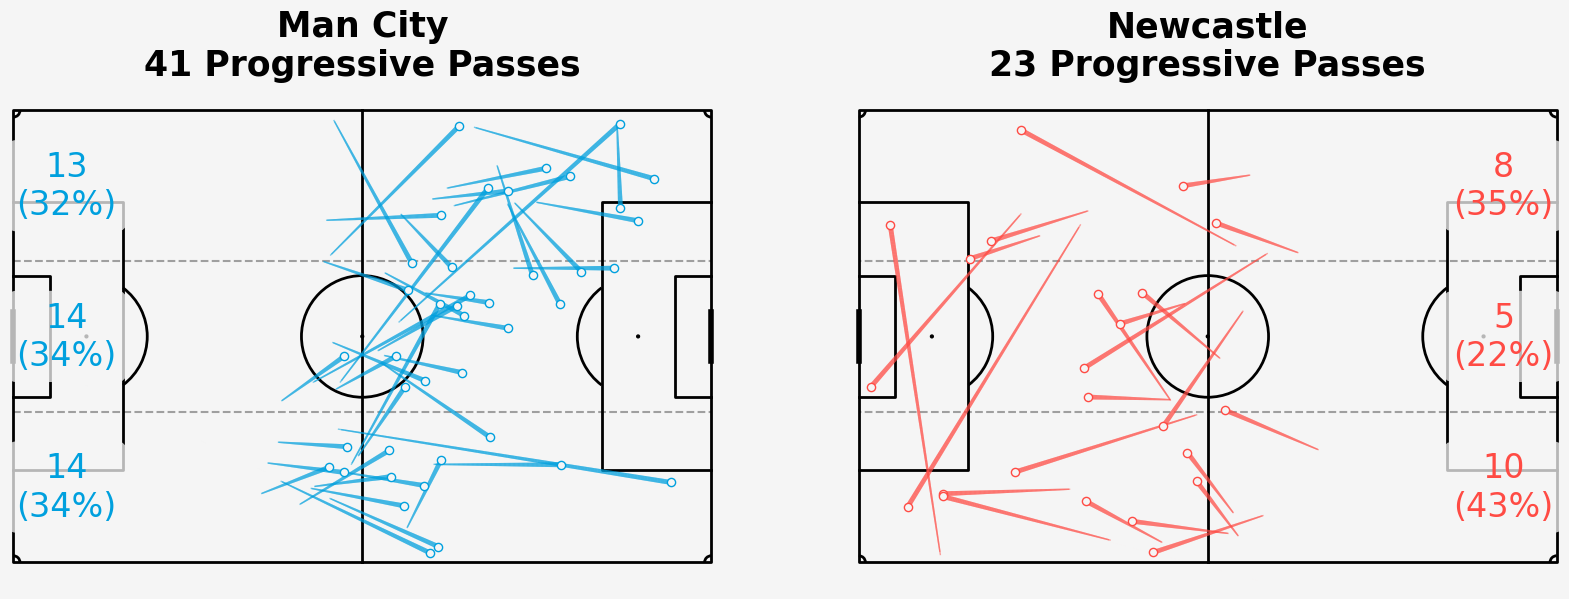

In [65]:
def draw_progressive_pass_map(ax, team_name, col):
    dfpro = df[(df['teamName']==team_name) & (df['prog_pass']>=9.11) & (~df['qualifiers'].str.contains('CornerTaken|Freekick')) & 
    (df['x']>=35) & (df['outcomeType']=='Successful')]
    # df_pen = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['endX']>=88.5) & (df['endY']>=13.6) & (df['endY']<=54.4) &
    #             ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6))]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=45.33])
    mid_pro = len(dfpro[(dfpro['y']>=22.67) & (dfpro['y']<45.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<22.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpro.x, dfpro.y, dfpro.endX, dfpro.endY, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpro.endX, dfpro.endY, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)

    counttext = f"{pro_count} Progressive Passes"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Passes': pro_count,
        'Progressive_Passes_From_Left': left_pro,
        'Progressive_Passes_From_Center': mid_pro,
        'Progressive_Passes_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Passes_Stats_home = draw_progressive_pass_map(axs[0], hteamName, hcol)
Progressvie_Passes_Stats_away = draw_progressive_pass_map(axs[1], ateamName, acol)
Progressvie_Passes_Stats_list = []
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_home)
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_away)
Progressvie_Passes_Stats_df = pd.DataFrame(Progressvie_Passes_Stats_list)

In [66]:
Progressvie_Passes_Stats_df

Team_Name  Total_Progressive_Passes  Progressive_Passes_From_Left  \
0   Man City                        41                            13   
1  Newcastle                        23                            10   

   Progressive_Passes_From_Center  Progressive_Passes_From_Right  
0                              14                             14  
1                               5                              8

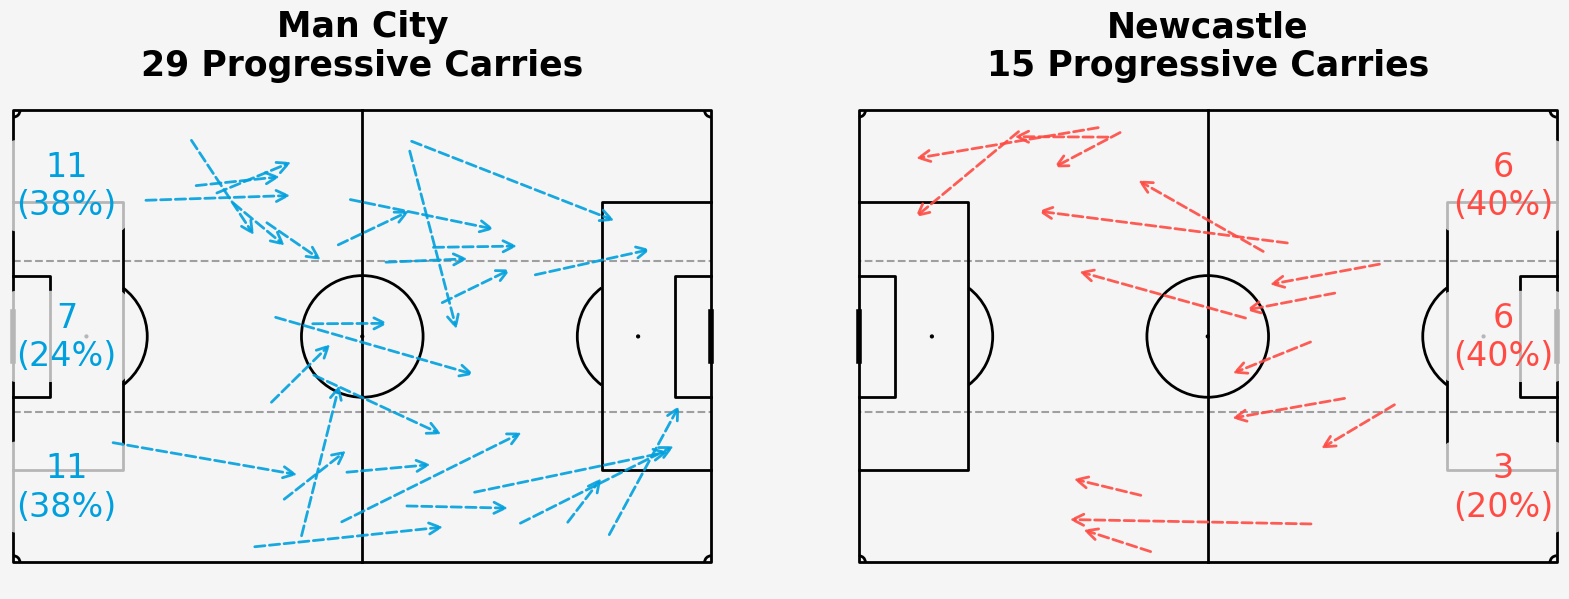

In [67]:
def draw_progressive_carry_map(ax, team_name, col):
    dfpro = df[(df['teamName']==team_name) & (df['prog_carry']>=9.11) & (df['endX']>=35)]
    # df_pen = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['endX']>=88.5) & (df['endY']>=13.6) & (df['endY']<=54.4) &
    #             ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6))]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=45.33])
    mid_pro = len(dfpro[(dfpro['y']>=22.67) & (dfpro['y']<45.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<22.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the carries
    for index, row in dfpro.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=0.9, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pro_count} Progressive Carries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Carries': pro_count,
        'Progressive_Carries_From_Left': left_pro,
        'Progressive_Carries_From_Center': mid_pro,
        'Progressive_Carries_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Carries_Stats_home = draw_progressive_carry_map(axs[0], hteamName, hcol)
Progressvie_Carries_Stats_away = draw_progressive_carry_map(axs[1], ateamName, acol)
Progressvie_Carries_Stats_list = []
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_home)
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_away)
Progressvie_Carries_Stats_df = pd.DataFrame(Progressvie_Carries_Stats_list)

In [68]:
Progressvie_Carries_Stats_df

Team_Name  Total_Progressive_Carries  Progressive_Carries_From_Left  \
0   Man City                         29                             11   
1  Newcastle                         15                              3   

   Progressive_Carries_From_Center  Progressive_Carries_From_Right  
0                                7                              11  
1                                6                               6

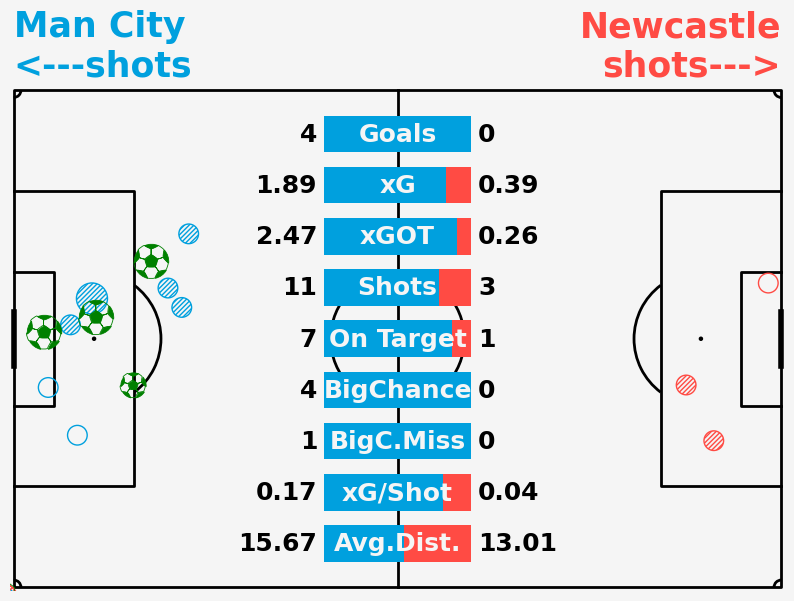

In [69]:
# filtering the shots only
mask4 = (df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')
Shotsdf = df[mask4]
Shotsdf = Shotsdf.reset_index(drop=True)

# filtering according to the types of shots
hShotsdf = Shotsdf[Shotsdf['teamName']==hteamName]
aShotsdf = Shotsdf[Shotsdf['teamName']==ateamName]
hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,'))]
aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,'))]
hogdf = hShotsdf[(hShotsdf['teamName']==hteamName) & (hShotsdf['qualifiers'].str.contains('OwnGoal'))]
aogdf = aShotsdf[(aShotsdf['teamName']==ateamName) & (aShotsdf['qualifiers'].str.contains('OwnGoal'))]

# Center Goal point
given_point = (105, 34)
# Calculate distances
home_shot_distances = np.sqrt((hShotsdf['x'] - given_point[0])**2 + (hShotsdf['y'] - given_point[1])**2)
home_average_shot_distance = round(home_shot_distances.mean(),2)
away_shot_distances = np.sqrt((aShotsdf['x'] - given_point[0])**2 + (aShotsdf['y'] - given_point[1])**2)
away_average_shot_distance = round(away_shot_distances.mean(),2)

def plot_shotmap(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, linewidth=2, line_color=line_color)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)
    
    #shooting stats
    hTotalShots = len(hShotsdf)
    aTotalShots = len(aShotsdf)
    hShotsOnT = len(hSavedf) + hgoal_count
    aShotsOnT = len(aSavedf) + agoal_count
    hxGpSh = round(hxg/hTotalShots, 2)
    axGpSh = round(axg/hTotalShots, 2)
    
    # without big chances for home team
    hGoalData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hPostData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hSaveData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hMissData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of home team
    Big_C_hGoalData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hPostData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hSaveData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hMissData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    total_bigC_home = len(Big_C_hGoalData) + len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)
    bigC_miss_home = len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)
    # normal shots scatter of home team
    sc2 = pitch.scatter((105-hPostData.x), (68-hPostData.y), s=200, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    sc3 = pitch.scatter((105-hSaveData.x), (68-hSaveData.y), s=200, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    sc4 = pitch.scatter((105-hMissData.x), (68-hMissData.y), s=200, edgecolors=hcol, c='None', marker='o', ax=ax)
    sc1 = pitch.scatter((105-hGoalData.x), (68-hGoalData.y), s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc1_og = pitch.scatter((105-hogdf.x), (68-hogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of home team
    bc_sc2 = pitch.scatter((105-Big_C_hPostData.x), (68-Big_C_hPostData.y), s=500, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    bc_sc3 = pitch.scatter((105-Big_C_hSaveData.x), (68-Big_C_hSaveData.y), s=500, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc4 = pitch.scatter((105-Big_C_hMissData.x), (68-Big_C_hMissData.y), s=500, edgecolors=hcol, c='None', marker='o', ax=ax)
    bc_sc1 = pitch.scatter((105-Big_C_hGoalData.x), (68-Big_C_hGoalData.y), s=650, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # without big chances for away team
    aGoalData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aPostData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aSaveData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aMissData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of away team
    Big_C_aGoalData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aPostData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aSaveData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aMissData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    total_bigC_away = len(Big_C_aGoalData) + len(Big_C_aPostData) + len(Big_C_aSaveData) + len(Big_C_aMissData)
    bigC_miss_away = len(Big_C_aPostData) + len(Big_C_aSaveData) + len(Big_C_aMissData)
    # normal shots scatter of away team
    sc6 = pitch.scatter(aPostData.x, aPostData.y, s=200, edgecolors=acol, c=acol, marker='o', ax=ax)
    sc7 = pitch.scatter(aSaveData.x, aSaveData.y, s=200, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    sc8 = pitch.scatter(aMissData.x, aMissData.y, s=200, edgecolors=acol, c='None', marker='o', ax=ax)
    sc5 = pitch.scatter(aGoalData.x, aGoalData.y, s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc5_og = pitch.scatter((aogdf.x), (aogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of away team
    bc_sc6 = pitch.scatter(Big_C_aPostData.x, Big_C_aPostData.y, s=700, edgecolors=acol, c=acol, marker='o', ax=ax)
    bc_sc7 = pitch.scatter(Big_C_aSaveData.x, Big_C_aSaveData.y, s=700, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc8 = pitch.scatter(Big_C_aMissData.x, Big_C_aMissData.y, s=700, edgecolors=acol, c='None', marker='o', ax=ax)
    bc_sc5 = pitch.scatter(Big_C_aGoalData.x, Big_C_aGoalData.y, s=850, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # sometimes the both teams ends the match 0-0, then normalizing the data becomes problem, thats why this part of the code
    if hgoal_count+agoal_count == 0:
       hgoal = 10
       agoal = 10
    else:
       hgoal = (hgoal_count/(hgoal_count+agoal_count))*20
       agoal = (agoal_count/(hgoal_count+agoal_count))*20
        
    if total_bigC_home+total_bigC_away == 0:
       total_bigC_home_n = 10
       total_bigC_away_n = 10
    else:
       total_bigC_home_n = (total_bigC_home/(total_bigC_home+total_bigC_away))*20
       total_bigC_away_n = (total_bigC_away/(total_bigC_home+total_bigC_away))*20
        
    if bigC_miss_home+bigC_miss_away == 0:
       bigC_miss_home_n = 10
       bigC_miss_away_n = 10
    else:
       bigC_miss_home_n = (bigC_miss_home/(bigC_miss_home+bigC_miss_away))*20
       bigC_miss_away_n = (bigC_miss_away/(bigC_miss_home+bigC_miss_away))*20

    if hShotsOnT+aShotsOnT == 0:
       hShotsOnT_n = 10
       aShotsOnT_n = 10
    else:
       hShotsOnT_n = (hShotsOnT/(hShotsOnT+aShotsOnT))*20
       aShotsOnT_n = (aShotsOnT/(hShotsOnT+aShotsOnT))*20

    if hxgot+axgot == 0:
       hxgot_n = 10
       axgot_n = 10
    else:
       hxgot_n = (hxgot/(hxgot+axgot))*20
       axgot_n = (axgot/(hxgot+axgot))*20

    # Stats bar diagram
    shooting_stats_title = [62, 62-(1*7), 62-(2*7), 62-(3*7), 62-(4*7), 62-(5*7), 62-(6*7), 62-(7*7), 62-(8*7)]
    shooting_stats_home = [hgoal_count, hxg, hxgot, hTotalShots, hShotsOnT, hxGpSh, total_bigC_home, bigC_miss_home, home_average_shot_distance]
    shooting_stats_away = [agoal_count, axg, axgot, aTotalShots, aShotsOnT, axGpSh, total_bigC_away, bigC_miss_away, away_average_shot_distance]

    # normalizing the stats
    shooting_stats_normalized_home = [hgoal, (hxg/(hxg+axg))*20, hxgot_n,
                                      (hTotalShots/(hTotalShots+aTotalShots))*20, hShotsOnT_n,
                                      total_bigC_home_n, bigC_miss_home_n,
                                      (hxGpSh/(hxGpSh+axGpSh))*20, 
                                      (home_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]
    shooting_stats_normalized_away = [agoal, (axg/(hxg+axg))*20, axgot_n,
                                      (aTotalShots/(hTotalShots+aTotalShots))*20, aShotsOnT_n,
                                      total_bigC_away_n, bigC_miss_away_n,
                                      (axGpSh/(hxGpSh+axGpSh))*20,
                                      (away_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]

    # definig the start point
    start_x = 42.5
    start_x_for_away = [x + 42.5 for x in shooting_stats_normalized_home]
    ax.barh(shooting_stats_title, shooting_stats_normalized_home, height=5, color=hcol, left=start_x)
    ax.barh(shooting_stats_title, shooting_stats_normalized_away, height=5, left=start_x_for_away, color=acol)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # plotting the texts
    ax.text(52.5, 62, "Goals", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(1*7), "xG", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(2*7), "xGOT", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(3*7), "Shots", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(4*7), "On Target", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(5*7), "BigChance", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(6*7), "BigC.Miss", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(7*7), "xG/Shot", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(8*7), "Avg.Dist.", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')

    ax.text(41.5, 62, f"{hgoal_count}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(1*7), f"{hxg}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(2*7), f"{hxgot}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(3*7), f"{hTotalShots}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(4*7), f"{hShotsOnT}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(5*7), f"{total_bigC_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(6*7), f"{bigC_miss_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(7*7), f"{hxGpSh}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(8*7), f"{home_average_shot_distance}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')

    ax.text(63.5, 62, f"{agoal_count}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(1*7), f"{axg}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(2*7), f"{axgot}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(3*7), f"{aTotalShots}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(4*7), f"{aShotsOnT}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(5*7), f"{total_bigC_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(6*7), f"{bigC_miss_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(7*7), f"{axGpSh}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(8*7), f"{away_average_shot_distance}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')

    # Heading and other texts
    ax.text(0, 70, f"{hteamName}\n<---shots", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nshots--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Goals_Scored': hgoal_count,
        'xG': hxg,
        'xGOT': hxgot,
        'Total_Shots': hTotalShots,
        'Shots_On_Target': hShotsOnT,
        'BigChances': total_bigC_home,
        'BigChances_Missed': bigC_miss_home,
        'xG_per_Shot': hxGpSh,
        'Average_Shot_Distance': home_average_shot_distance
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Goals_Scored': agoal_count,
        'xG': axg,
        'xGOT': axgot,
        'Total_Shots': aTotalShots,
        'Shots_On_Target': aShotsOnT,
        'BigChances': total_bigC_away,
        'BigChances_Missed': bigC_miss_away,
        'xG_per_Shot': axGpSh,
        'Average_Shot_Distance': away_average_shot_distance
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
shooting_stats = plot_shotmap(ax)
shooting_stats_df = pd.DataFrame(shooting_stats)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3281878704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3281878704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3281878704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

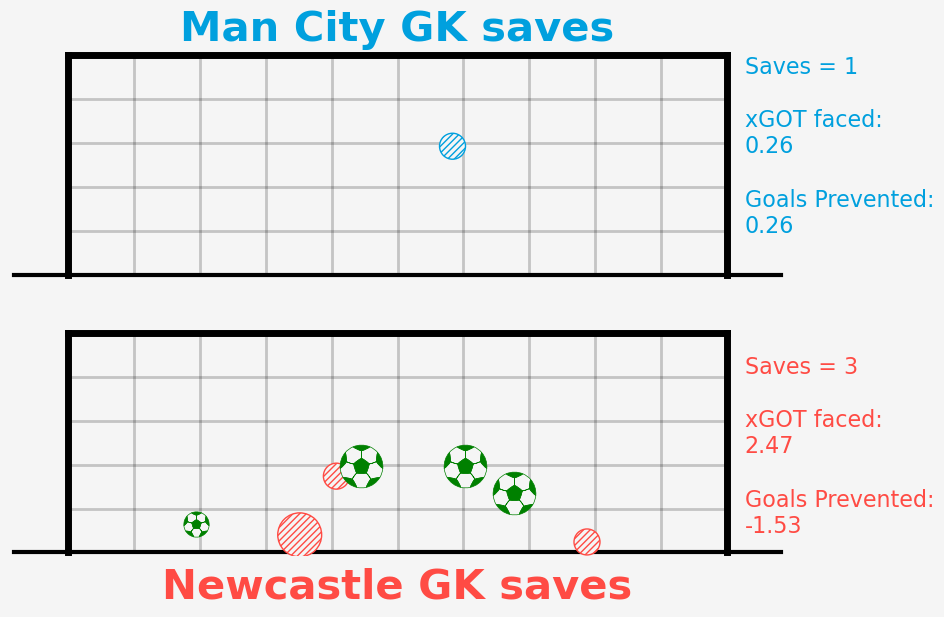

In [70]:
def plot_goalPost(ax):
    hShotsdf = Shotsdf[Shotsdf['teamName']==hteamName]
    aShotsdf = Shotsdf[Shotsdf['teamName']==ateamName]
    # converting the datapoints according to the pitch dimension, because the goalposts are being plotted inside the pitch using pitch's dimension
    hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
    aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38

    hShotsdf['goalMouthY'] = ((37.66 - hShotsdf['goalMouthY'])*12.295) + 7.5
    aShotsdf['goalMouthY'] = ((37.66 - aShotsdf['goalMouthY'])*12.295) + 7.5

    # plotting an invisible pitch using the pitch color and line color same color, because the goalposts are being plotted inside the pitch using pitch's dimension
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    # away goalpost bars
    ax.plot([7.5, 7.5], [0, 30], color=line_color, linewidth=5)
    ax.plot([7.5, 97.5], [30, 30], color=line_color, linewidth=5)
    ax.plot([97.5, 97.5], [30, 0], color=line_color, linewidth=5)
    ax.plot([0, 105], [0, 0], color=line_color, linewidth=3)
    # plotting the away net
    y_values = np.arange(0, 6) * 6
    for y in y_values:
        ax.plot([7.5, 97.5], [y, y], color=line_color, linewidth=2, alpha=0.2)
    x_values = (np.arange(0, 11) * 9) + 7.5
    for x in x_values:
        ax.plot([x, x], [0, 30], color=line_color, linewidth=2, alpha=0.2)
    # home goalpost bars
    ax.plot([7.5, 7.5], [38, 68], color=line_color, linewidth=5)
    ax.plot([7.5, 97.5], [68, 68], color=line_color, linewidth=5)
    ax.plot([97.5, 97.5], [68, 38], color=line_color, linewidth=5)
    ax.plot([0, 105], [38, 38], color=line_color, linewidth=3)
    # plotting the home net
    y_values = (np.arange(0, 6) * 6) + 38
    for y in y_values:
        ax.plot([7.5, 97.5], [y, y], color=line_color, linewidth=2, alpha=0.2)
    x_values = (np.arange(0, 11) * 9) + 7.5
    for x in x_values:
        ax.plot([x, x], [38, 68], color=line_color, linewidth=2, alpha=0.2)

    # filtering different types of shots without BigChance
    hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,')) & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    hGoaldf = hShotsdf[(hShotsdf['type']=='Goal') & (~hShotsdf['qualifiers'].str.contains('OwnGoal')) & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    hPostdf = hShotsdf[(hShotsdf['type']=='ShotOnPost') & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,')) & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    aGoaldf = aShotsdf[(aShotsdf['type']=='Goal') & (~aShotsdf['qualifiers'].str.contains('OwnGoal')) & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    aPostdf = aShotsdf[(aShotsdf['type']=='ShotOnPost') & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    # filtering different types of shots with BigChance
    hSavedf_bc = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,')) & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    hGoaldf_bc = hShotsdf[(hShotsdf['type']=='Goal') & (~hShotsdf['qualifiers'].str.contains('OwnGoal')) & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    hPostdf_bc = hShotsdf[(hShotsdf['type']=='ShotOnPost') & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    aSavedf_bc = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,')) & (aShotsdf['qualifiers'].str.contains('BigChance'))]
    aGoaldf_bc = aShotsdf[(aShotsdf['type']=='Goal') & (~aShotsdf['qualifiers'].str.contains('OwnGoal')) & (aShotsdf['qualifiers'].str.contains('BigChance'))]
    aPostdf_bc = aShotsdf[(aShotsdf['type']=='ShotOnPost') & (aShotsdf['qualifiers'].str.contains('BigChance'))]

    # scattering those shots without BigChance
    sc1 = pitch.scatter(hSavedf.goalMouthY, hSavedf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=acol, hatch='/////', s=350, ax=ax)
    sc2 = pitch.scatter(hGoaldf.goalMouthY, hGoaldf.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=350, ax=ax)
    sc3 = pitch.scatter(hPostdf.goalMouthY, hPostdf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=350, ax=ax)
    sc4 = pitch.scatter(aSavedf.goalMouthY, aSavedf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=hcol, hatch='/////', s=350, ax=ax)
    sc5 = pitch.scatter(aGoaldf.goalMouthY, aGoaldf.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=350, ax=ax)
    sc6 = pitch.scatter(aPostdf.goalMouthY, aPostdf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=350, ax=ax)
    # scattering those shots with BigChance
    sc1_bc = pitch.scatter(hSavedf_bc.goalMouthY, hSavedf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=acol, hatch='/////', s=1000, ax=ax)
    sc2_bc = pitch.scatter(hGoaldf_bc.goalMouthY, hGoaldf_bc.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=1000, ax=ax)
    sc3_bc = pitch.scatter(hPostdf_bc.goalMouthY, hPostdf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=1000, ax=ax)
    sc4_bc = pitch.scatter(aSavedf_bc.goalMouthY, aSavedf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=hcol, hatch='/////', s=1000, ax=ax)
    sc5_bc = pitch.scatter(aGoaldf_bc.goalMouthY, aGoaldf_bc.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=1000, ax=ax)
    sc6_bc = pitch.scatter(aPostdf_bc.goalMouthY, aPostdf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=1000, ax=ax)

    # Headlines and other texts
    ax.text(52.5, 70, f"{hteamName} GK saves", color=hcol, fontsize=30, ha='center', fontweight='bold')
    ax.text(52.5, -2, f"{ateamName} GK saves", color=acol, fontsize=30, ha='center', va='top', fontweight='bold')

    ax.text(100, 68, f"Saves = {len(aSavedf)+len(aSavedf_bc)}\n\nxGOT faced:\n{axgot}\n\nGoals Prevented:\n{round(axgot - len(aGoaldf) - len(aGoaldf_bc),2)}",
                    color=hcol, fontsize=16, va='top', ha='left')
    ax.text(100, 2, f"Saves = {len(hSavedf)+len(hSavedf_bc)}\n\nxGOT faced:\n{hxgot}\n\nGoals Prevented:\n{round(hxgot - len(hGoaldf) - len(hGoaldf_bc),2)}",
                    color=acol, fontsize=16, va='bottom', ha='left')

    home_data = {
        'Team_Name': hteamName,
        'Shots_Saved': len(hSavedf)+len(hSavedf_bc),
        'Big_Chance_Saved': len(hSavedf_bc),
        'Goals_Prevented': round(hxgot - len(hGoaldf) - len(hGoaldf_bc),2)
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Shots_Saved': len(aSavedf)+len(aSavedf_bc),
        'Big_Chance_Saved': len(aSavedf_bc),
        'Goals_Prevented': round(axgot - len(aGoaldf) - len(aGoaldf_bc),2)
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
goalkeeping_stats = plot_goalPost(ax)
goalkeeping_stats_df = pd.DataFrame(goalkeeping_stats)

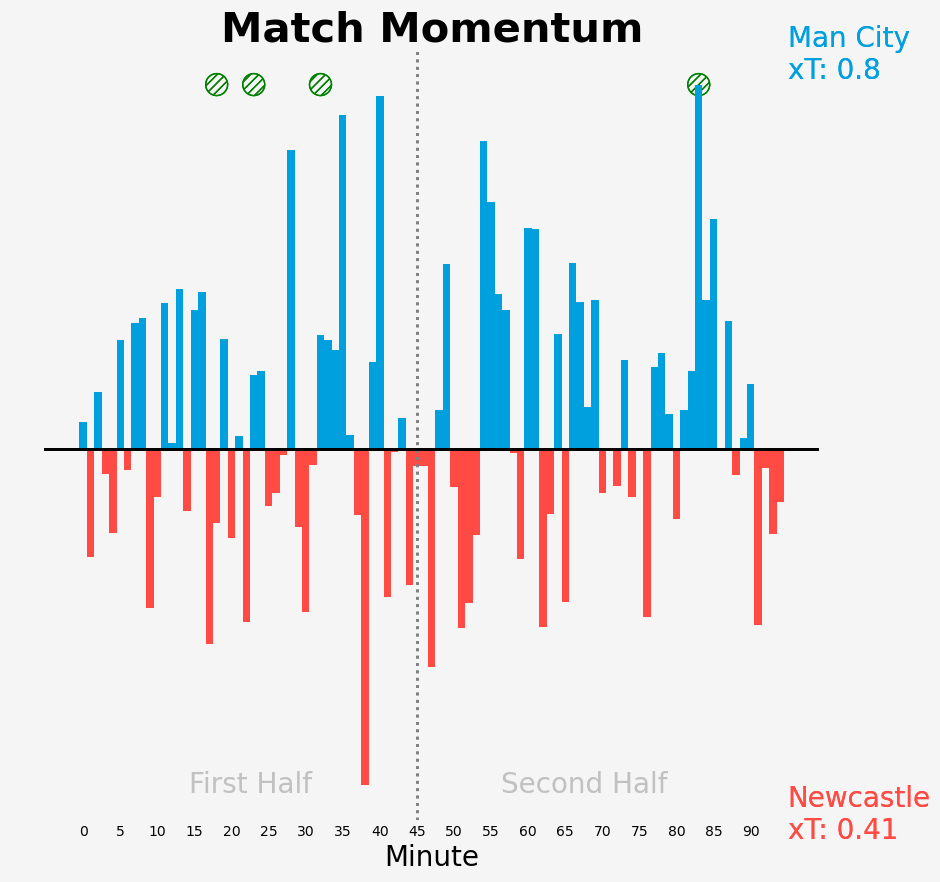

In [71]:
u_df = df.copy()
u_df = u_df[~u_df['qualifiers'].str.contains('CornerTaken')]
u_df = u_df[['x', 'minute', 'type', 'teamName']]
u_df = u_df[~u_df['type'].isin(['Start', 'OffsidePass', 'OffsideProvoked', 'Card', 'CornerAwarded', 'End', 
                                'OffsideGiven', 'SubstitutionOff', 'SubstitutionOn', 'FormationChange', 'FormationSet'])].reset_index(drop=True)
u_df.loc[u_df['teamName'] == ateamName, 'x'] = 105 - u_df.loc[u_df['teamName'] == ateamName, 'x']

Momentumdf = u_df.groupby('minute')['x'].mean()
Momentumdf = Momentumdf.reset_index()
Momentumdf.columns = ['minute', 'average_x']
Momentumdf['average_x'] = Momentumdf['average_x'] - 52.5

def plot_Momentum(ax):
    # Set colors based on positive or negative values
    colors = [hcol if x > 0 else acol for x in Momentumdf['average_x']]

    # making a list of munutes when goals are scored
    hgoal_list = homedf[(homedf['type'] == 'Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    agoal_list = awaydf[(awaydf['type'] == 'Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    hog_list = homedf[(homedf['type'] == 'Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    aog_list = awaydf[(awaydf['type'] == 'Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    hred_list = homedf[homedf['qualifiers'].str.contains('Red|SecondYellow')]['minute'].tolist()
    ared_list = awaydf[awaydf['qualifiers'].str.contains('Red|SecondYellow')]['minute'].tolist()

    # plotting scatters when goals are scored
    highest_x = Momentumdf['average_x'].max()
    lowest_x = Momentumdf['average_x'].min()
    highest_minute = Momentumdf['minute'].max()
    hscatter_y = [highest_x]*len(hgoal_list)
    ascatter_y = [lowest_x]*len(agoal_list)
    hogscatter_y = [highest_x]*len(aog_list)
    aogscatter_y = [lowest_x]*len(hog_list)
    hred_y = [highest_x]*len(hred_list)
    ared_y = [lowest_x]*len(ared_list)

    ax.text((45/2), lowest_x, 'First Half', color='gray', fontsize=20, alpha=0.25, va='center', ha='center')
    ax.text((45+(45/2)), lowest_x, 'Second Half', color='gray', fontsize=20, alpha=0.25, va='center', ha='center')

    ax.scatter(hgoal_list, hscatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
    ax.scatter(agoal_list, ascatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
    ax.scatter(hog_list, aogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')
    ax.scatter(aog_list, hogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')
    ax.scatter(hred_list, hred_y, s=250, c='None', edgecolor='red', hatch='////', marker='s')
    ax.scatter(ared_list, ared_y, s=250, c='None', edgecolor='red', hatch='////', marker='s')

    # Creating the bar plot
    ax.bar(Momentumdf['minute'], Momentumdf['average_x'], width=1, color=colors)
    ax.set_xticks(range(0, len(Momentumdf['minute']), 5))
    ax.axvline(45, color='gray', linewidth=2, linestyle='dotted')
    # ax.axvline(90, color='gray', linewidth=2, linestyle='dotted')
    ax.set_facecolor(bg_color)
    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # # Hide ticks
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', colors=line_color)
    ax.tick_params(axis='y', colors=bg_color)
    # Add labels and title
    ax.set_xlabel('Minute', color=line_color, fontsize=20)
    # ax.set_ylabel('Avg. xT per minute', color=line_color, fontsize=20)
    ax.axhline(y=0, color=line_color, alpha=1, linewidth=2)

    ax.text(highest_minute+1,highest_x, f"{hteamName}\nxT: {hxT}", color=hcol, fontsize=20, va='bottom', ha='left')
    ax.text(highest_minute+1,lowest_x,  f"{ateamName}\nxT: {axT}", color=acol, fontsize=20, va='top', ha='left')

    ax.set_title('Match Momentum', color=line_color, fontsize=30, fontweight='bold')
    
    home_data = {
        'Team_Name': hteamName,
        'xT': hxT
    }
    
    away_data = {
        'Team_Name': ateamName,
        'xT': axT
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
plot_Momentum(ax)
xT_stats = plot_Momentum(ax)
xT_stats_df = pd.DataFrame(xT_stats)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3175358258.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3175358258.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_goalkick['length'] = home_goalkick['qualifiers'].apply(extract_length).astype(float)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3175358258.py:74: Se

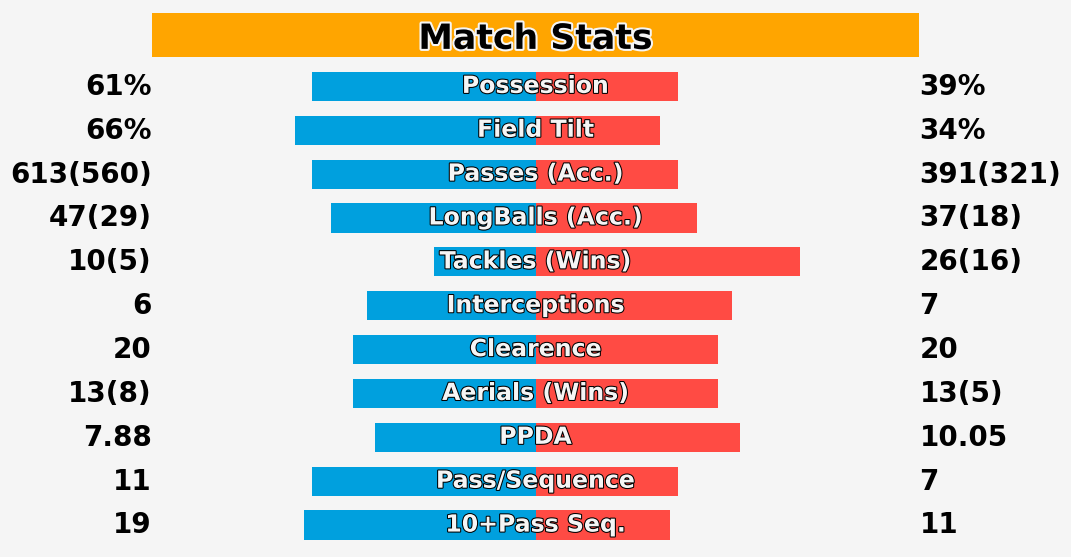

In [92]:
#Here I have calculated a lot of stats, all of them I couldn't show in the viz because of lack of spaces, but I kept those in the code
# Passing Stats
#Possession%
hpossdf = df[(df['teamName']==hteamName) & (df['type']=='Pass')]
apossdf = df[(df['teamName']==ateamName) & (df['type']=='Pass')]
hposs = round((len(hpossdf)/(len(hpossdf)+len(apossdf)))*100,2)
aposs = round((len(apossdf)/(len(hpossdf)+len(apossdf)))*100,2)
#Field Tilt%
hftdf = df[(df['teamName']==hteamName) & (df['isTouch']==1) & (df['x']>=70)]
aftdf = df[(df['teamName']==ateamName) & (df['isTouch']==1) & (df['x']>=70)]
hft = round((len(hftdf)/(len(hftdf)+len(aftdf)))*100,2)
aft = round((len(aftdf)/(len(hftdf)+len(aftdf)))*100,2)
#Total Passes
htotalPass = len(df[(df['teamName']==hteamName) & (df['type']=='Pass')])
atotalPass = len(df[(df['teamName']==ateamName) & (df['type']=='Pass')])
#Accurate Pass
hAccPass = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
aAccPass = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
#Accurate Pass (without defensive third)
hAccPasswdt = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['endX']>35)])
aAccPasswdt = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['endX']>35)])
#LongBall
hLongB = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aLongB = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Accurate LongBall
hAccLongB = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aAccLongB = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Crosses
hCrss= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
aCrss= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
#Accurate Crosses
hAccCrss= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
aAccCrss= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
#Freekick
hfk= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
afk= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
#Corner
hCor= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
aCor= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
#ThrowIn
htins= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
atins= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
#GoalKicks
hglkk= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
aglkk= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
#Dribbling
htotalDrb = len(df[(df['teamName']==hteamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
atotalDrb = len(df[(df['teamName']==ateamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
#Accurate TakeOn
hAccDrb = len(df[(df['teamName']==hteamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
aAccDrb = len(df[(df['teamName']==ateamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
#GoalKick Length
home_goalkick = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
away_goalkick = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
import ast
if len(home_goalkick) != 0:
    # Convert 'qualifiers' column from string to list of dictionaries
    home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
    # Function to extract value of 'Length'
    def extract_length(qualifiers):
        for item in qualifiers:
            if 'displayName' in item['type'] and item['type']['displayName'] == 'Length':
                return float(item['value'])
        return None
    # Apply the function to the 'qualifiers' column
    home_goalkick['length'] = home_goalkick['qualifiers'].apply(extract_length).astype(float)
    hglkl = round(home_goalkick['length'].mean(),2)

else:
    hglkl = 0

if len(away_goalkick) != 0:
    # Convert 'qualifiers' column from string to list of dictionaries
    away_goalkick['qualifiers'] = away_goalkick['qualifiers'].apply(ast.literal_eval)
    # Function to extract value of 'Length'
    def extract_length(qualifiers):
        for item in qualifiers:
            if 'displayName' in item['type'] and item['type']['displayName'] == 'Length':
                return float(item['value'])
        return None
    # Apply the function to the 'qualifiers' column
    away_goalkick['length'] = away_goalkick['qualifiers'].apply(extract_length).astype(float)
    aglkl = round(away_goalkick['length'].mean(),2)

else:
    aglkl = 0


# Defensive Stats

#Tackles
htkl = len(df[(df['teamName']==hteamName) & (df['type']=='Tackle')])
atkl = len(df[(df['teamName']==ateamName) & (df['type']=='Tackle')])
#Tackles Won
htklw = len(df[(df['teamName']==hteamName) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
atklw = len(df[(df['teamName']==ateamName) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
#Interceptions
hintc= len(df[(df['teamName']==hteamName) & (df['type']=='Interception')])
aintc= len(df[(df['teamName']==ateamName) & (df['type']=='Interception')])
#Clearances
hclr= len(df[(df['teamName']==hteamName) & (df['type']=='Clearance')])
aclr= len(df[(df['teamName']==ateamName) & (df['type']=='Clearance')])
#Aerials
harl= len(df[(df['teamName']==hteamName) & (df['type']=='Aerial')])
aarl= len(df[(df['teamName']==ateamName) & (df['type']=='Aerial')])
#Aerials Wins
harlw= len(df[(df['teamName']==hteamName) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
aarlw= len(df[(df['teamName']==ateamName) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
#BallRecovery
hblrc= len(df[(df['teamName']==hteamName) & (df['type']=='BallRecovery')])
ablrc= len(df[(df['teamName']==ateamName) & (df['type']=='BallRecovery')])
#BlockedPass
hblkp= len(df[(df['teamName']==hteamName) & (df['type']=='BlockedPass')])
ablkp= len(df[(df['teamName']==ateamName) & (df['type']=='BlockedPass')])
#OffsideGiven
hofs= len(df[(df['teamName']==hteamName) & (df['type']=='OffsideGiven')])
aofs= len(df[(df['teamName']==ateamName) & (df['type']=='OffsideGiven')])
#Fouls
hfoul= len(df[(df['teamName']==hteamName) & (df['type']=='Foul')])
afoul= len(df[(df['teamName']==ateamName) & (df['type']=='Foul')])

# PPDA
home_def_acts = df[(df['teamName']==hteamName) & (df['type'].str.contains('Interception|Foul|Challenge|BlockedPass|Tackle')) & (df['x']>35)]
away_def_acts = df[(df['teamName']==ateamName) & (df['type'].str.contains('Interception|Foul|Challenge|BlockedPass|Tackle')) & (df['x']>35)]
home_pass = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['x']<70)]
away_pass = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['x']<70)]
home_ppda = round((len(away_pass)/len(home_def_acts)), 2)
away_ppda = round((len(home_pass)/len(away_def_acts)), 2)

# Average Passes per Sequence
pass_df_home = df[(df['type'] == 'Pass') & (df['teamName']==hteamName)]
pass_counts_home = pass_df_home.groupby('possession_id').size()
PPS_home = pass_counts_home.mean().round()
pass_df_away = df[(df['type'] == 'Pass') & (df['teamName']==ateamName)]
pass_counts_away = pass_df_away.groupby('possession_id').size()
PPS_away = pass_counts_away.mean().round()

# Number of Sequence with 10+ Passes
possessions_with_10_or_more_passes = pass_counts_home[pass_counts_home >= 10]
pass_seq_10_more_home = possessions_with_10_or_more_passes.count()
possessions_with_10_or_more_passes = pass_counts_away[pass_counts_away >= 10]
pass_seq_10_more_away = possessions_with_10_or_more_passes.count()

path_eff1 = [path_effects.Stroke(linewidth=1.5, foreground=line_color), path_effects.Normal()]

def plotting_match_stats(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-5, 68.5)

    # plotting the headline box
    head_y = [62,68,68,62]
    head_x = [0,0,105,105]
    ax.fill(head_x, head_y, 'orange')
    ax.text(52.5,64.5, "Match Stats", ha='center', va='center', color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

    # Stats bar diagram
    stats_title = [58, 58-(1*6), 58-(2*6), 58-(3*6), 58-(4*6), 58-(5*6), 58-(6*6), 58-(7*6), 58-(8*6), 58-(9*6), 58-(10*6)] # y co-ordinate values of the bars
    stats_home = [hposs, hft, htotalPass, hLongB, htkl, hintc, hclr, harl, home_ppda, PPS_home, pass_seq_10_more_home]
    stats_away = [aposs, aft, atotalPass, aLongB, atkl, aintc, aclr, aarl, away_ppda, PPS_away, pass_seq_10_more_away]

    stats_normalized_home = [-(hposs/(hposs+aposs))*50, -(hft/(hft+aft))*50, -(htotalPass/(htotalPass+atotalPass))*50,
                             -(hLongB/(hLongB+aLongB))*50, -(htkl/(htkl+atkl))*50,       # put a (-) sign before each value so that the
                             -(hintc/(hintc+aintc))*50, -(hclr/(hclr+aclr))*50, -(harl/(harl+aarl))*50, -(home_ppda/(home_ppda+away_ppda))*50,
                             -(PPS_home/(PPS_home+PPS_away))*50, -(pass_seq_10_more_home/(pass_seq_10_more_home+pass_seq_10_more_away))*50]          # home stats bar shows in the opposite of away
    stats_normalized_away = [(aposs/(hposs+aposs))*50, (aft/(hft+aft))*50, (atotalPass/(htotalPass+atotalPass))*50,
                             (aLongB/(hLongB+aLongB))*50, (atkl/(htkl+atkl))*50,
                             (aintc/(hintc+aintc))*50, (aclr/(hclr+aclr))*50, (aarl/(harl+aarl))*50, (away_ppda/(home_ppda+away_ppda))*50,
                             (PPS_away/(PPS_home+PPS_away))*50, (pass_seq_10_more_away/(pass_seq_10_more_home+pass_seq_10_more_away))*50]

    start_x = 52.5
    ax.barh(stats_title, stats_normalized_home, height=4, color=col1, left=start_x)
    ax.barh(stats_title, stats_normalized_away, height=4, left=start_x, color=col2)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plotting the texts
    ax.text(52.5, 58, "Possession", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(1*6), "Field Tilt", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(2*6), "Passes (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(3*6), "LongBalls (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(4*6), "Tackles (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(5*6), "Interceptions", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(6*6), "Clearence", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(7*6), "Aerials (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(8*6), "PPDA", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(9*6), "Pass/Sequence", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(10*6), "10+Pass Seq.", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)

    ax.text(0, 58, f"{round(hposs)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(1*6), f"{round(hft)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(2*6), f"{htotalPass}({hAccPass})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(3*6), f"{hLongB}({hAccLongB})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(4*6), f"{htkl}({htklw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(5*6), f"{hintc}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(6*6), f"{hclr}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(7*6), f"{harl}({harlw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(8*6), f"{home_ppda}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(9*6), f"{int(PPS_home)}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(10*6), f"{pass_seq_10_more_home}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')

    ax.text(105, 58, f"{round(aposs)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(1*6), f"{round(aft)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(2*6), f"{atotalPass}({aAccPass})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(3*6), f"{aLongB}({aAccLongB})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(4*6), f"{atkl}({atklw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(5*6), f"{aintc}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(6*6), f"{aclr}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(7*6), f"{aarl}({aarlw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(8*6), f"{away_ppda}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(9*6), f"{int(PPS_away)}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(10*6), f"{pass_seq_10_more_away}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Possession_%': hposs,
        'Field_Tilt_%': hft,
        'Total_Passes': htotalPass,
        'Accurate_Passes': hAccPass,
        'Longballs': hLongB,
        'Accurate_Longballs': hAccLongB,
        'Corners': hCor,
        'Avg.GoalKick_Length': hglkl,
        'Tackles': htkl,
        'Tackles_Won': htklw,
        'Interceptions': hintc,
        'Clearances': hclr,
        'Aerial_Duels': harl,
        'Aerial_Duels_Won': harlw,
        'Passes_Per_Defensive_Actions(PPDA)': home_ppda,
        'Average_Passes_Per_Sequences': PPS_home,
        '10+_Passing_Sequences': pass_seq_10_more_home
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Possession_%': aposs,
        'Field_Tilt_%': aft,
        'Total_Passes': atotalPass,
        'Accurate_Passes': aAccPass,
        'Longballs': aLongB,
        'Accurate_Longballs': aAccLongB,
        'Corners': aCor,
        'Avg.GoalKick_Length': aglkl,
        'Tackles': atkl,
        'Tackles_Won': atklw,
        'Interceptions': aintc,
        'Clearances': aclr,
        'Aerial_Duels': aarl,
        'Aerial_Duels_Won': aarlw,
        'Passes_Per_Defensive_Actions(PPDA)': away_ppda,
        'Average_Passes_Per_Sequences': PPS_away,
        '10+_Passing_Sequences': pass_seq_10_more_away
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
general_match_stats = plotting_match_stats(ax)
general_match_stats_df = pd.DataFrame(general_match_stats)

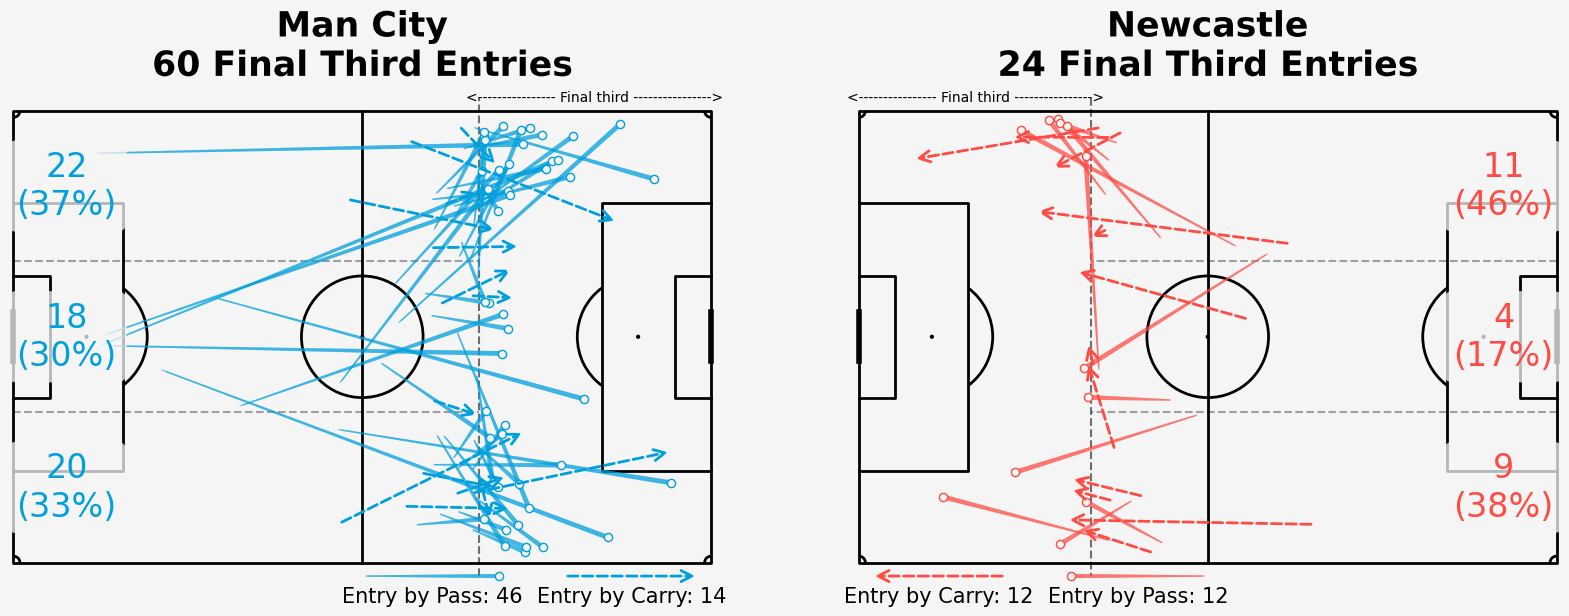

In [73]:
def Final_third_entry(ax, team_name, col):
    dfpass = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['x']<70) & (df['endX']>=70) & (df['outcomeType']=='Successful') &
                (~df['qualifiers'].str.contains('Freekick'))]
    dfcarry = df[(df['teamName']==team_name) & (df['type']=='Carry') & (df['x']<70) & (df['endX']>=70)]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pass_count = len(dfpass) + len(dfcarry)

    # calculating the counts
    left_entry = len(dfpass[dfpass['y']>=45.33]) + len(dfcarry[dfcarry['y']>=45.33])
    mid_entry = len(dfpass[(dfpass['y']>=22.67) & (dfpass['y']<45.33)]) + len(dfcarry[(dfcarry['y']>=22.67) & (dfcarry['y']<45.33)])
    right_entry = len(dfpass[(dfpass['y']>=0) & (dfpass['y']<22.67)]) + len(dfcarry[(dfcarry['y']>=0) & (dfcarry['y']<22.67)])
    left_percentage = round((left_entry/pass_count)*100)
    mid_percentage = round((mid_entry/pass_count)*100)
    right_percentage = round((right_entry/pass_count)*100)

    ax.hlines(22.67, xmin=0, xmax=70, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=70, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.vlines(70, ymin=-2, ymax=70, colors=line_color, linestyle='dashed', alpha=0.55)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpass.x, dfpass.y, dfpass.endX, dfpass.endY, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpass.endX, dfpass.endY, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)
    # plotting carries
    for index, row in dfcarry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pass_count} Final Third Entries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, 70, '<---------------- Final third ---------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, -2, 73, -2, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,-2, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, -2), (103, -2), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, -5, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, -5, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')
        
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, -2, '<---------------- Final third ---------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, 70, 73, 70, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,70, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, 70), (103, 70), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, 73, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, 73, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')

    return {
        'Team_Name': team_name,
        'Total_Final_Third_Entries': pass_count,
        'Final_Third_Entries_From_Left': left_entry,
        'Final_Third_Entries_From_Center': mid_entry,
        'Final_Third_Entries_From_Right': right_entry,
        'Entry_By_Pass': len(dfpass),
        'Entry_By_Carry': len(dfcarry)
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
final_third_entry_stats_home = Final_third_entry(axs[0], hteamName, hcol)
final_third_entry_stats_away = Final_third_entry(axs[1], ateamName, acol)
final_third_entry_stats_list = []
final_third_entry_stats_list.append(final_third_entry_stats_home)
final_third_entry_stats_list.append(final_third_entry_stats_away)
final_third_entry_stats_df = pd.DataFrame(final_third_entry_stats_list)

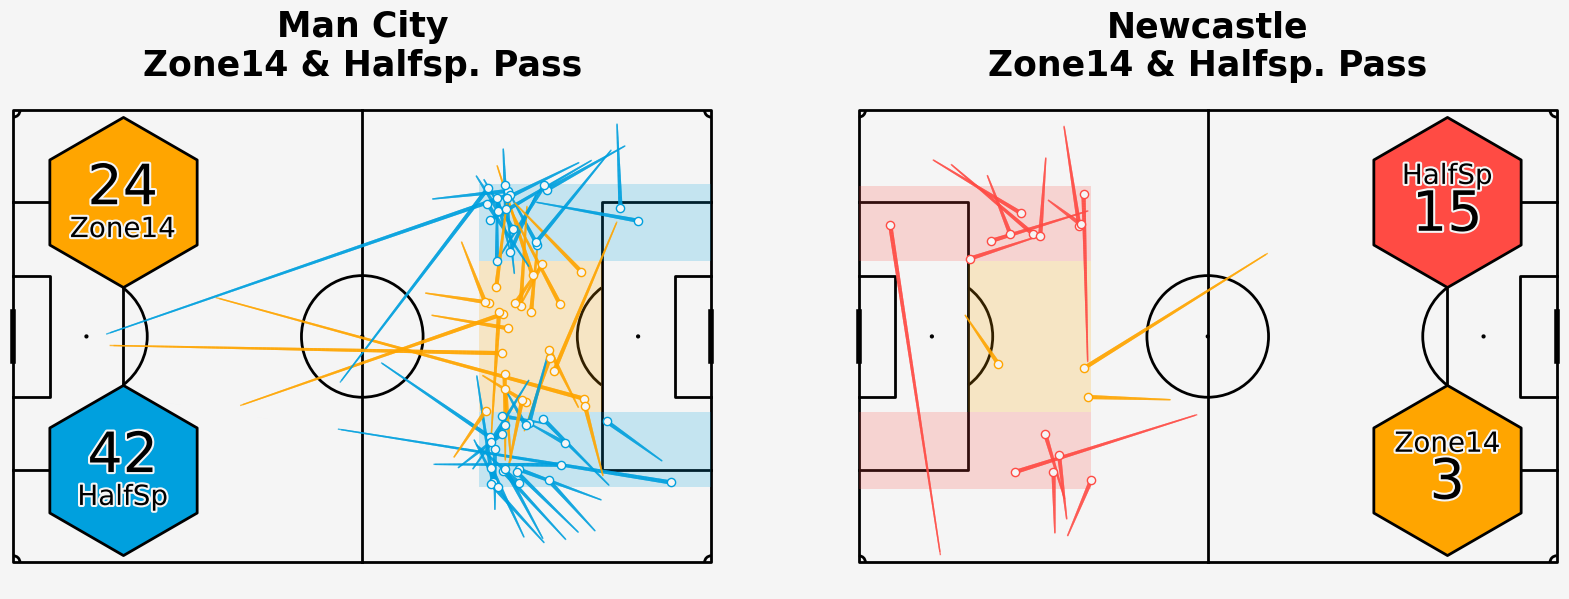

In [94]:
def zone14hs(ax, team_name, col):
    dfhp = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & 
              (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color,  linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_facecolor(bg_color)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    # setting the count varibale
    z14 = 0
    hs = 0
    lhs = 0
    rhs = 0

    path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]
    # iterating ecah pass and according to the conditions plotting only zone14 and half spaces passes
    for index, row in dfhp.iterrows():
        if row['endX'] >= 70 and row['endX'] <= 88.54 and row['endY'] >= 22.66 and row['endY'] <= 45.32:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color='orange', comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor='orange', zorder=4)
            z14 += 1
        if row['endX'] >= 70 and row['endY'] >= 11.33 and row['endY'] <= 22.66:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            rhs += 1
        if row['endX'] >= 70 and row['endY'] >= 45.32 and row['endY'] <= 56.95:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            lhs += 1

    # coloring those zones in the pitch
    y_z14 = [22.66, 22.66, 45.32, 45.32]
    x_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'orange', alpha=0.2, label='Zone14')

    y_rhs = [11.33, 11.33, 22.66, 22.66]
    x_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    y_lhs = [45.32, 45.32, 56.95, 56.95]
    x_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    # showing the counts in an attractive way
    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(16.46, 13.85, color=col, s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.scatter(16.46, 54.15, color='orange', s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.text(16.46, 13.85-4, hsname, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15-4, z14name, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 13.85+2, hscount, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15+2, z14count, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)

    # Headings and other texts
    if col == hcol:
      ax.set_title(f"{hteamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')
    else:
      ax.set_title(f"{ateamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Passes_Into_Zone14': z14,
        'Passes_Into_Halfspaces': hs,
        'Passes_Into_Left_Halfspaces': lhs,
        'Passes_Into_Right_Halfspaces': rhs
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
zonal_passing_stats_home = zone14hs(axs[0], hteamName, hcol)
zonal_passing_stats_away = zone14hs(axs[1], ateamName, acol)
zonal_passing_stats_list = []
zonal_passing_stats_list.append(zonal_passing_stats_home)
zonal_passing_stats_list.append(zonal_passing_stats_away)
zonal_passing_stats_df = pd.DataFrame(zonal_passing_stats_list)

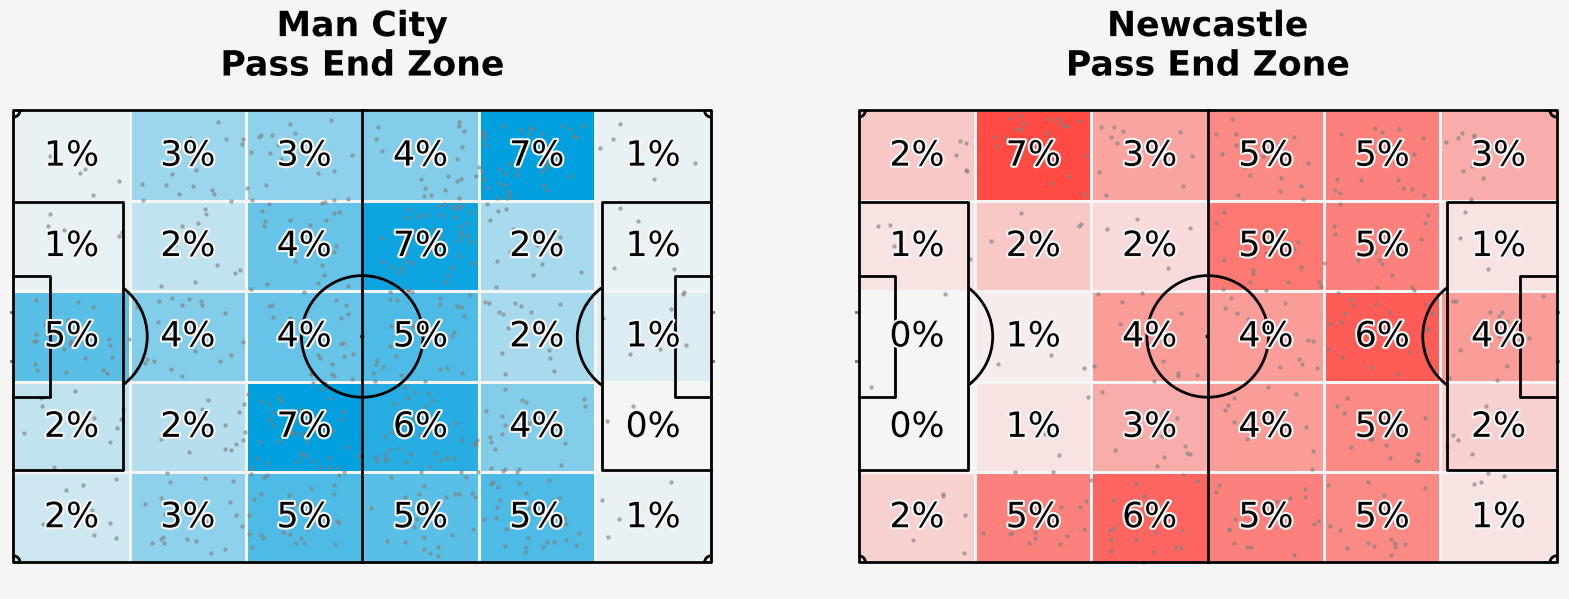

In [75]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Pass_end_zone(ax, team_name, cm):
    pez = df[(df['teamName'] == team_name) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')]
    pitch = Pitch(pitch_type='uefa', line_color=line_color, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    pearl_earring_cmap = cm
    # binning the data points
    # bin_statistic = pitch.bin_statistic_positional(df.endX, df.endY, statistic='count', positional='full', normalize=True)
    bin_statistic = pitch.bin_statistic(pez.endX, pez.endY, bins=(6, 5), normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors=bg_color)
    pitch.scatter(pez.endX, pez.endY, c='gray', alpha=0.5, s=5, ax=ax)
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)

    # Headings and other texts
    if team_name == hteamName:
      ax.set_title(f"{hteamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
      ax.set_title(f"{ateamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Pass_end_zone(axs[0], hteamName, pearl_earring_cmaph)
Pass_end_zone(axs[1], ateamName, pearl_earring_cmapa)

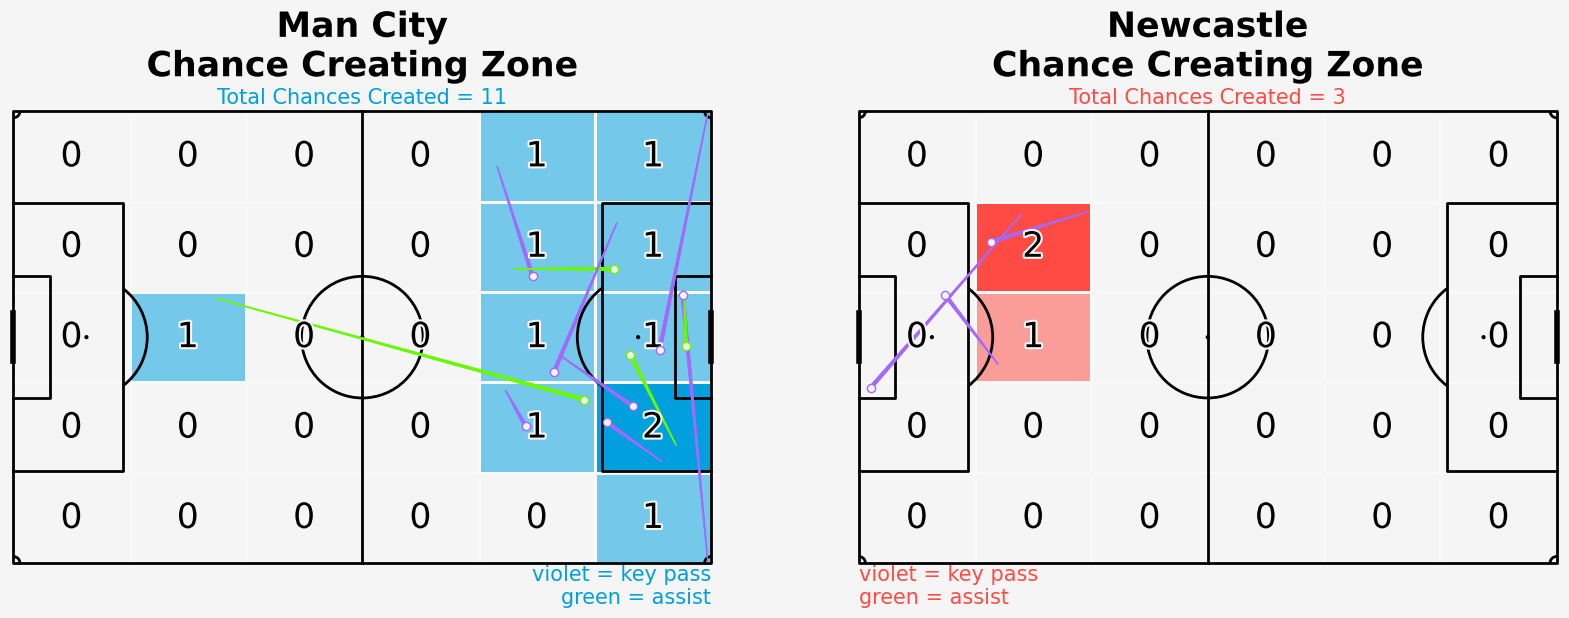

In [76]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Chance_creating_zone(ax, team_name, cm, col):
    ccp = df[(df['qualifiers'].str.contains('KeyPass')) & (df['teamName']==team_name)]
    pitch = Pitch(pitch_type='uefa', line_color=line_color, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    cc = 0
    pearl_earring_cmap = cm
    # bin_statistic = pitch.bin_statistic_positional(df.x, df.y, statistic='count', positional='full', normalize=False)
    bin_statistic = pitch.bin_statistic(ccp.x, ccp.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors='#f8f8f8')
    # pitch.scatter(ccp.x, ccp.y, c='gray', s=5, ax=ax)
    for index, row in ccp.iterrows():
      if 'IntentionalGoalAssist' in row['qualifiers']:
        pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=green, comet=True, lw=3, zorder=3, ax=ax)
        ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=green, zorder=4)
        cc += 1
      else :
        pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, comet=True, lw=3, zorder=3, ax=ax)
        ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=violet, zorder=4)
        cc += 1
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)
    teamName = team_name

    # Headings and other texts
    if col == hcol:
      ax.text(105,-3.5, "violet = key pass\ngreen = assist", color=hcol, size=15, ha='right', va='center')
      ax.text(52.5,70, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
      ax.set_title(f"{hteamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(105,71.5, "violet = key pass\ngreen = assist", color=acol, size=15, ha='left', va='center')
      ax.text(52.5,-2, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
      ax.set_title(f"{ateamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

    return {
        'Team_Name': team_name,
        'Total_Chances_Created': cc
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
chance_creating_stats_home = Chance_creating_zone(axs[0], hteamName, pearl_earring_cmaph, hcol)
chance_creating_stats_away = Chance_creating_zone(axs[1], ateamName, pearl_earring_cmapa, acol)
chance_creating_stats_list = []
chance_creating_stats_list.append(chance_creating_stats_home)
chance_creating_stats_list.append(chance_creating_stats_away)
chance_creating_stats_df = pd.DataFrame(chance_creating_stats_list)

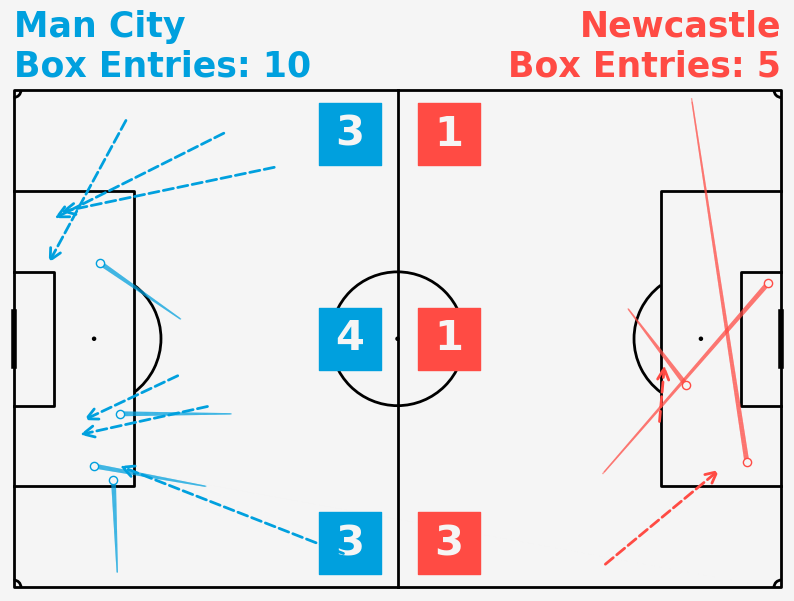

In [77]:
def box_entry(ax):
    bentry = df[((df['type']=='Pass')|(df['type']=='Carry')) & (df['outcomeType']=='Successful') & (df['endX']>=88.5) &
                 ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6)) & (df['endY']>=13.6) & (df['endY']<=54.4) &
            (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    hbentry = bentry[bentry['teamName']==hteamName]
    abentry = bentry[bentry['teamName']==ateamName]

    hrigt = hbentry[hbentry['y']<68/3]
    hcent = hbentry[(hbentry['y']>=68/3) & (hbentry['y']<=136/3)]
    hleft = hbentry[hbentry['y']>136/3]

    arigt = abentry[(abentry['y']<68/3)]
    acent = abentry[(abentry['y']>=68/3) & (abentry['y']<=136/3)]
    aleft = abentry[(abentry['y']>136/3)]

    pitch = Pitch(pitch_type='uefa', line_color=line_color, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    for index, row in bentry.iterrows():
        if row['teamName'] == ateamName:
            color = acol
            x, y, endX, endY = row['x'], row['y'], row['endX'], row['endY']
        elif row['teamName'] == hteamName:
            color = hcol
            x, y, endX, endY = 105 - row['x'], 68 - row['y'], 105 - row['endX'], 68 - row['endY']
        else:
            continue  # Skip rows that don't match either team name

        if row['type'] == 'Pass':
            pitch.lines(x, y, endX, endY, lw=3.5, comet=True, color=color, ax=ax, alpha=0.5)
            pitch.scatter(endX, endY, s=35, edgecolor=color, linewidth=1, color=bg_color, zorder=2, ax=ax)
        elif row['type'] == 'Carry':
            arrow = patches.FancyArrowPatch((x, y), (endX, endY), arrowstyle='->', color=color, zorder=4, mutation_scale=20, 
                                            alpha=1, linewidth=2, linestyle='--')
            ax.add_patch(arrow)

    
    ax.text(0, 69, f'{hteamName}\nBox Entries: {len(hbentry)}', color=hcol, fontsize=25, fontweight='bold', ha='left', va='bottom')
    ax.text(105, 69, f'{ateamName}\nBox Entries: {len(abentry)}', color=acol, fontsize=25, fontweight='bold', ha='right', va='bottom')

    ax.scatter(46, 6, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 34, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 62, s=2000, marker='s', color=hcol, zorder=3)
    ax.text(46, 6, f'{len(hleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 34, f'{len(hcent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 62, f'{len(hrigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    ax.scatter(59.5, 6, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 34, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 62, s=2000, marker='s', color=acol, zorder=3)
    ax.text(59.5, 6, f'{len(arigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 34, f'{len(acent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 62, f'{len(aleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    home_data = {
        'Team_Name': hteamName,
        'Total_Box_Entries': len(hbentry),
        'Box_Entry_From_Left': len(hleft),
        'Box_Entry_From_Center': len(hcent),
        'Box_Entry_From_Right': len(hrigt)
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_Box_Entries': len(abentry),
        'Box_Entry_From_Left': len(aleft),
        'Box_Entry_From_Center': len(acent),
        'Box_Entry_From_Right': len(arigt)
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
box_entry_stats = box_entry(ax)
box_entry_stats_df = pd.DataFrame(box_entry_stats)

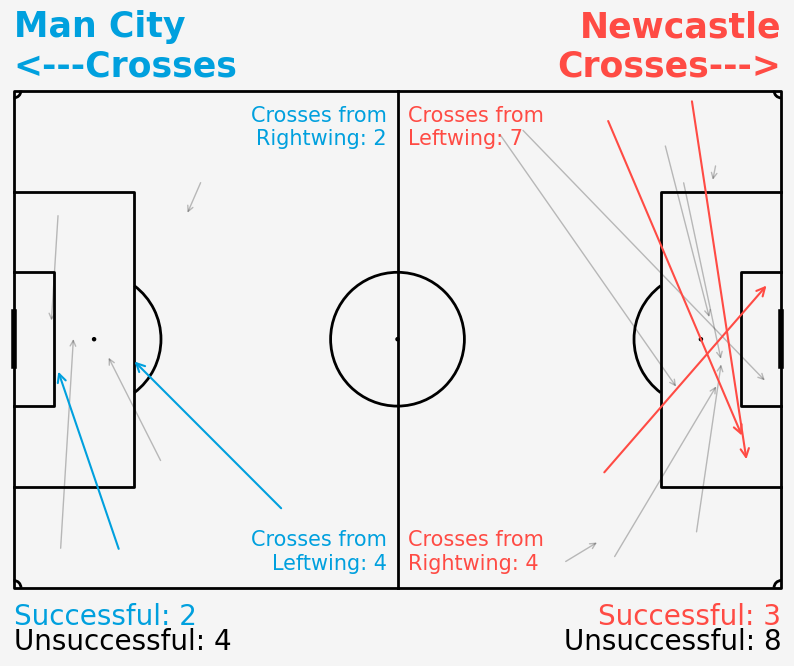

In [78]:
def Crosses(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    home_cross = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]
    away_cross = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]

    hsuc = 0
    hunsuc = 0
    asuc = 0
    aunsuc = 0

    # iterating through each pass and coloring according to successful or not
    for index, row in home_cross.iterrows():
        if row['outcomeType'] == 'Successful':
            arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=15, color=hcol, linewidth=1.5, zorder=3, alpha=1)
            ax.add_patch(arrow)
            hsuc += 1
        else:
            arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=10, color=line_color, linewidth=1, zorder=2, alpha=.25)
            ax.add_patch(arrow)
            hunsuc += 1

    for index, row in away_cross.iterrows():
        if row['outcomeType'] == 'Successful':
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=acol, linewidth=1.5, zorder=3, alpha=1)
            ax.add_patch(arrow)
            asuc += 1
        else:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=10, color=line_color, linewidth=1, zorder=2, alpha=.25)
            ax.add_patch(arrow)
            aunsuc += 1

    # Headlines and other texts
    home_left = len(home_cross[home_cross['y']>=34])
    home_right = len(home_cross[home_cross['y']<34])
    away_left = len(away_cross[away_cross['y']>=34])
    away_right = len(away_cross[away_cross['y']<34])

    ax.text(51, 2, f"Crosses from\nLeftwing: {home_left}", color=hcol, fontsize=15, va='bottom', ha='right')
    ax.text(51, 66, f"Crosses from\nRightwing: {home_right}", color=hcol, fontsize=15, va='top', ha='right')
    ax.text(54, 66, f"Crosses from\nLeftwing: {away_left}", color=acol, fontsize=15, va='top', ha='left')
    ax.text(54, 2, f"Crosses from\nRightwing: {away_right}", color=acol, fontsize=15, va='bottom', ha='left')

    ax.text(0,-2, f"Successful: {hsuc}", color=hcol, fontsize=20, ha='left', va='top')
    ax.text(0,-5.5, f"Unsuccessful: {hunsuc}", color=line_color, fontsize=20, ha='left', va='top')
    ax.text(105,-2, f"Successful: {asuc}", color=acol, fontsize=20, ha='right', va='top')
    ax.text(105,-5.5, f"Unsuccessful: {aunsuc}", color=line_color, fontsize=20, ha='right', va='top')

    ax.text(0, 70, f"{hteamName}\n<---Crosses", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nCrosses--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Total_Cross': hsuc + hunsuc,
        'Successful_Cross': hsuc,
        'Unsuccessful_Cross': hunsuc,
        'Cross_From_LeftWing': home_left,
        'Cross_From_RightWing': home_right
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_Cross': asuc + aunsuc,
        'Successful_Cross': asuc,
        'Unsuccessful_Cross': aunsuc,
        'Cross_From_LeftWing': away_left,
        'Cross_From_RightWing': away_right
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
cross_stats = Crosses(ax)
cross_stats_df = pd.DataFrame(cross_stats)

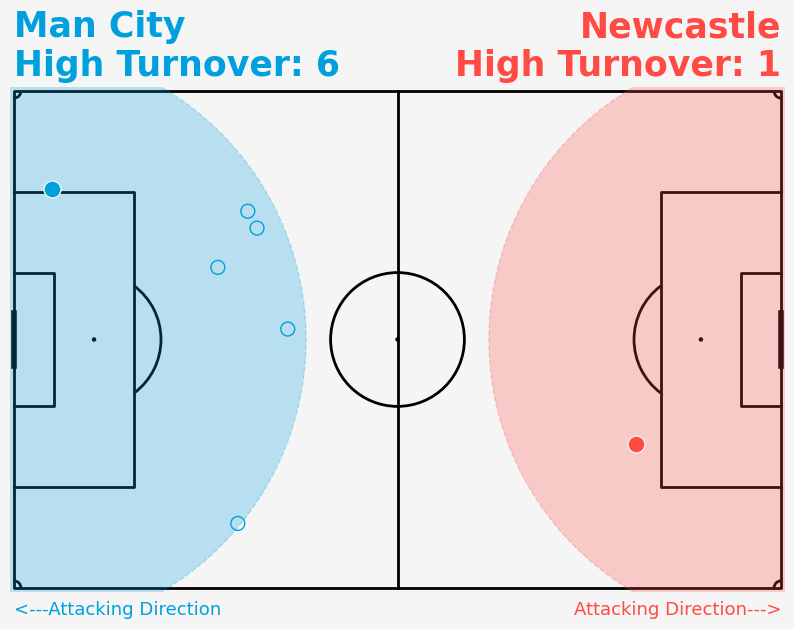

In [79]:
def HighTO(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    highTO = df.copy()
    highTO['Distance'] = ((highTO['x'] - 105)**2 + (highTO['y'] - 34)**2)**0.5

    agoal_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==ateamName:
                if highTO.loc[j, 'type'] == 'Goal' and highTO.loc[j, 'teamName']==ateamName:
                    ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=600, marker='*', color='green', edgecolor='k', zorder=3)
                    # print(highTO.loc[i, 'type'])
                    agoal_count += 1
                    break
                j += 1

    ashot_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==ateamName:
                if ('Shot' in highTO.loc[j, 'type']) and (highTO.loc[j, 'teamName']==ateamName):
                    ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=150, color=acol, edgecolor=bg_color, zorder=2)
                    ashot_count += 1
                    break
                j += 1
    
    aht_count = 0
    p_list = []
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            # Check the following rows
            j = i + 1
            if ((highTO.loc[j, 'teamName']==ateamName) and
                (highTO.loc[j, 'type']!='Dispossessed') and (highTO.loc[j, 'type']!='OffsidePass')):
                ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=100, color='None', edgecolor=acol)
                aht_count += 1
                p_list.append(highTO.loc[i, 'shortName'])





    
    hgoal_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==hteamName:
                if highTO.loc[j, 'type'] == 'Goal' and highTO.loc[j, 'teamName']==hteamName:
                    ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=600, marker='*', color='green', edgecolor='k', zorder=3)
                    # print(highTO.loc[i, 'name'])
                    hgoal_count += 1
                    break
                j += 1

    hshot_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==hteamName:
                if ('Shot' in highTO.loc[j, 'type']) and (highTO.loc[j, 'teamName']==hteamName):
                    ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=150, color=hcol, edgecolor=bg_color, zorder=2)
                    hshot_count += 1
                    break
                j += 1
    
    hht_count = 0
    p_list = []
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            # Check the following rows
            j = i + 1
            if ((highTO.loc[j, 'teamName']==hteamName) and
                (highTO.loc[j, 'type']!='Dispossessed') and (highTO.loc[j, 'type']!='OffsidePass')):
                ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=100, color='None', edgecolor=hcol)
                hht_count += 1
                p_list.append(highTO.loc[i, 'shortName'])

    # Plotting the half circle
    left_circle = plt.Circle((0,34), 40, color=hcol, fill=True, alpha=0.25, linestyle='dashed')
    ax.add_artist(left_circle)
    right_circle = plt.Circle((105,34), 40, color=acol, fill=True, alpha=0.25, linestyle='dashed')
    ax.add_artist(right_circle)
    # Set the aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')
    # Headlines and other texts
    ax.text(0, 70, f"{hteamName}\nHigh Turnover: {hht_count}", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nHigh Turnover: {aht_count}", color=acol, size=25, ha='right', fontweight='bold')
    ax.text(0,  -3, '<---Attacking Direction', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105,-3, 'Attacking Direction--->', color=acol, fontsize=13, ha='right', va='center')

    home_data = {
        'Team_Name': hteamName,
        'Total_High_Turnovers': hht_count,
        'Shot_Ending_High_Turnovers': hshot_count,
        'Goal_Ending_High_Turnovers': hgoal_count,
        'Opponent_Team_Name': ateamName
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_High_Turnovers': aht_count,
        'Shot_Ending_High_Turnovers': ashot_count,
        'Goal_Ending_High_Turnovers': agoal_count,
        'Opponent_Team_Name': hteamName
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
high_turnover_stats = HighTO(ax)
high_turnover_stats_df = pd.DataFrame(high_turnover_stats)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4285275424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4285275424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


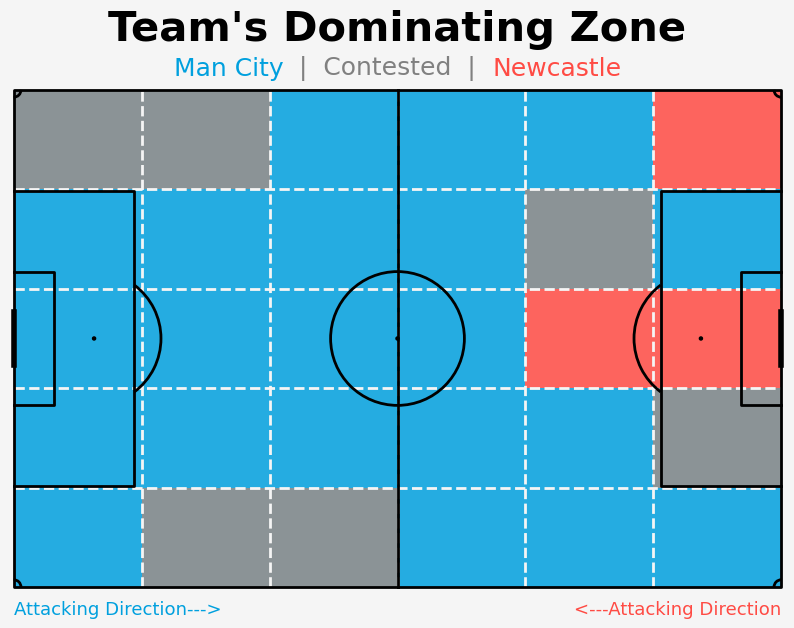

In [80]:
def plot_congestion(ax):
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [acol, 'gray', hcol], N=20)
    df1 = df[(df['teamName']==hteamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2 = df[(df['teamName']==ateamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2['x'] = 105-df2['x']
    df2['y'] =  68-df2['y']
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=6)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    bin_statistic1 = pitch.bin_statistic(df1.x, df1.y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(df2.x, df2.y, bins=(6,5), statistic='count', normalize=False)

    # Assuming 'cx' and 'cy' are as follows:
    cx = np.array([[ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25]])

    cy = np.array([[61.2, 61.2, 61.2, 61.2, 61.2, 61.2],
               [47.6, 47.6, 47.6, 47.6, 47.6, 47.6],
               [34.0, 34.0, 34.0, 34.0, 34.0, 34.0],
               [20.4, 20.4, 20.4, 20.4, 20.4, 20.4],
               [ 6.8,  6.8,  6.8,  6.8,  6.8,  6.8]])

    # Flatten the arrays
    cx_flat = cx.flatten()
    cy_flat = cy.flatten()

    # Create a DataFrame
    df_cong = pd.DataFrame({'cx': cx_flat, 'cy': cy_flat})

    hd_values = []


    # Loop through the 2D arrays
    for i in range(bin_statistic1['statistic'].shape[0]):
        for j in range(bin_statistic1['statistic'].shape[1]):
            stat1 = bin_statistic1['statistic'][i, j]
            stat2 = bin_statistic2['statistic'][i, j]
        
            if (stat1 / (stat1 + stat2)) > 0.55:
                hd_values.append(1)
            elif (stat1 / (stat1 + stat2)) < 0.45:
                hd_values.append(0)
            else:
                hd_values.append(0.5)

    df_cong['hd']=hd_values
    bin_stat = pitch.bin_statistic(df_cong.cx, df_cong.cy, bins=(6,5), values=df_cong['hd'], statistic='sum', normalize=False)
    pitch.heatmap(bin_stat, ax=ax, cmap=pcmap, edgecolors='#000000', lw=0, zorder=3, alpha=0.85)

    ax_text(52.5, 71, s=f"<{hteamName}>  |  Contested  |  <{ateamName}>", highlight_textprops=[{'color':hcol}, {'color':acol}],
            color='gray', fontsize=18, ha='center', va='center', ax=ax)
    ax.set_title("Team's Dominating Zone", color=line_color, fontsize=30, fontweight='bold', y=1.075)
    ax.text(0,  -3, 'Attacking Direction--->', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105,-3, '<---Attacking Direction', color=acol, fontsize=13, ha='right', va='center')

    ax.vlines(1*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(2*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(3*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(4*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(5*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)

    ax.hlines(1*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(2*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(3*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(4*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
plot_congestion(ax)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4223941635.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3281878704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/3281878704.py:6: SettingWithCopyWarning: 
A value is try

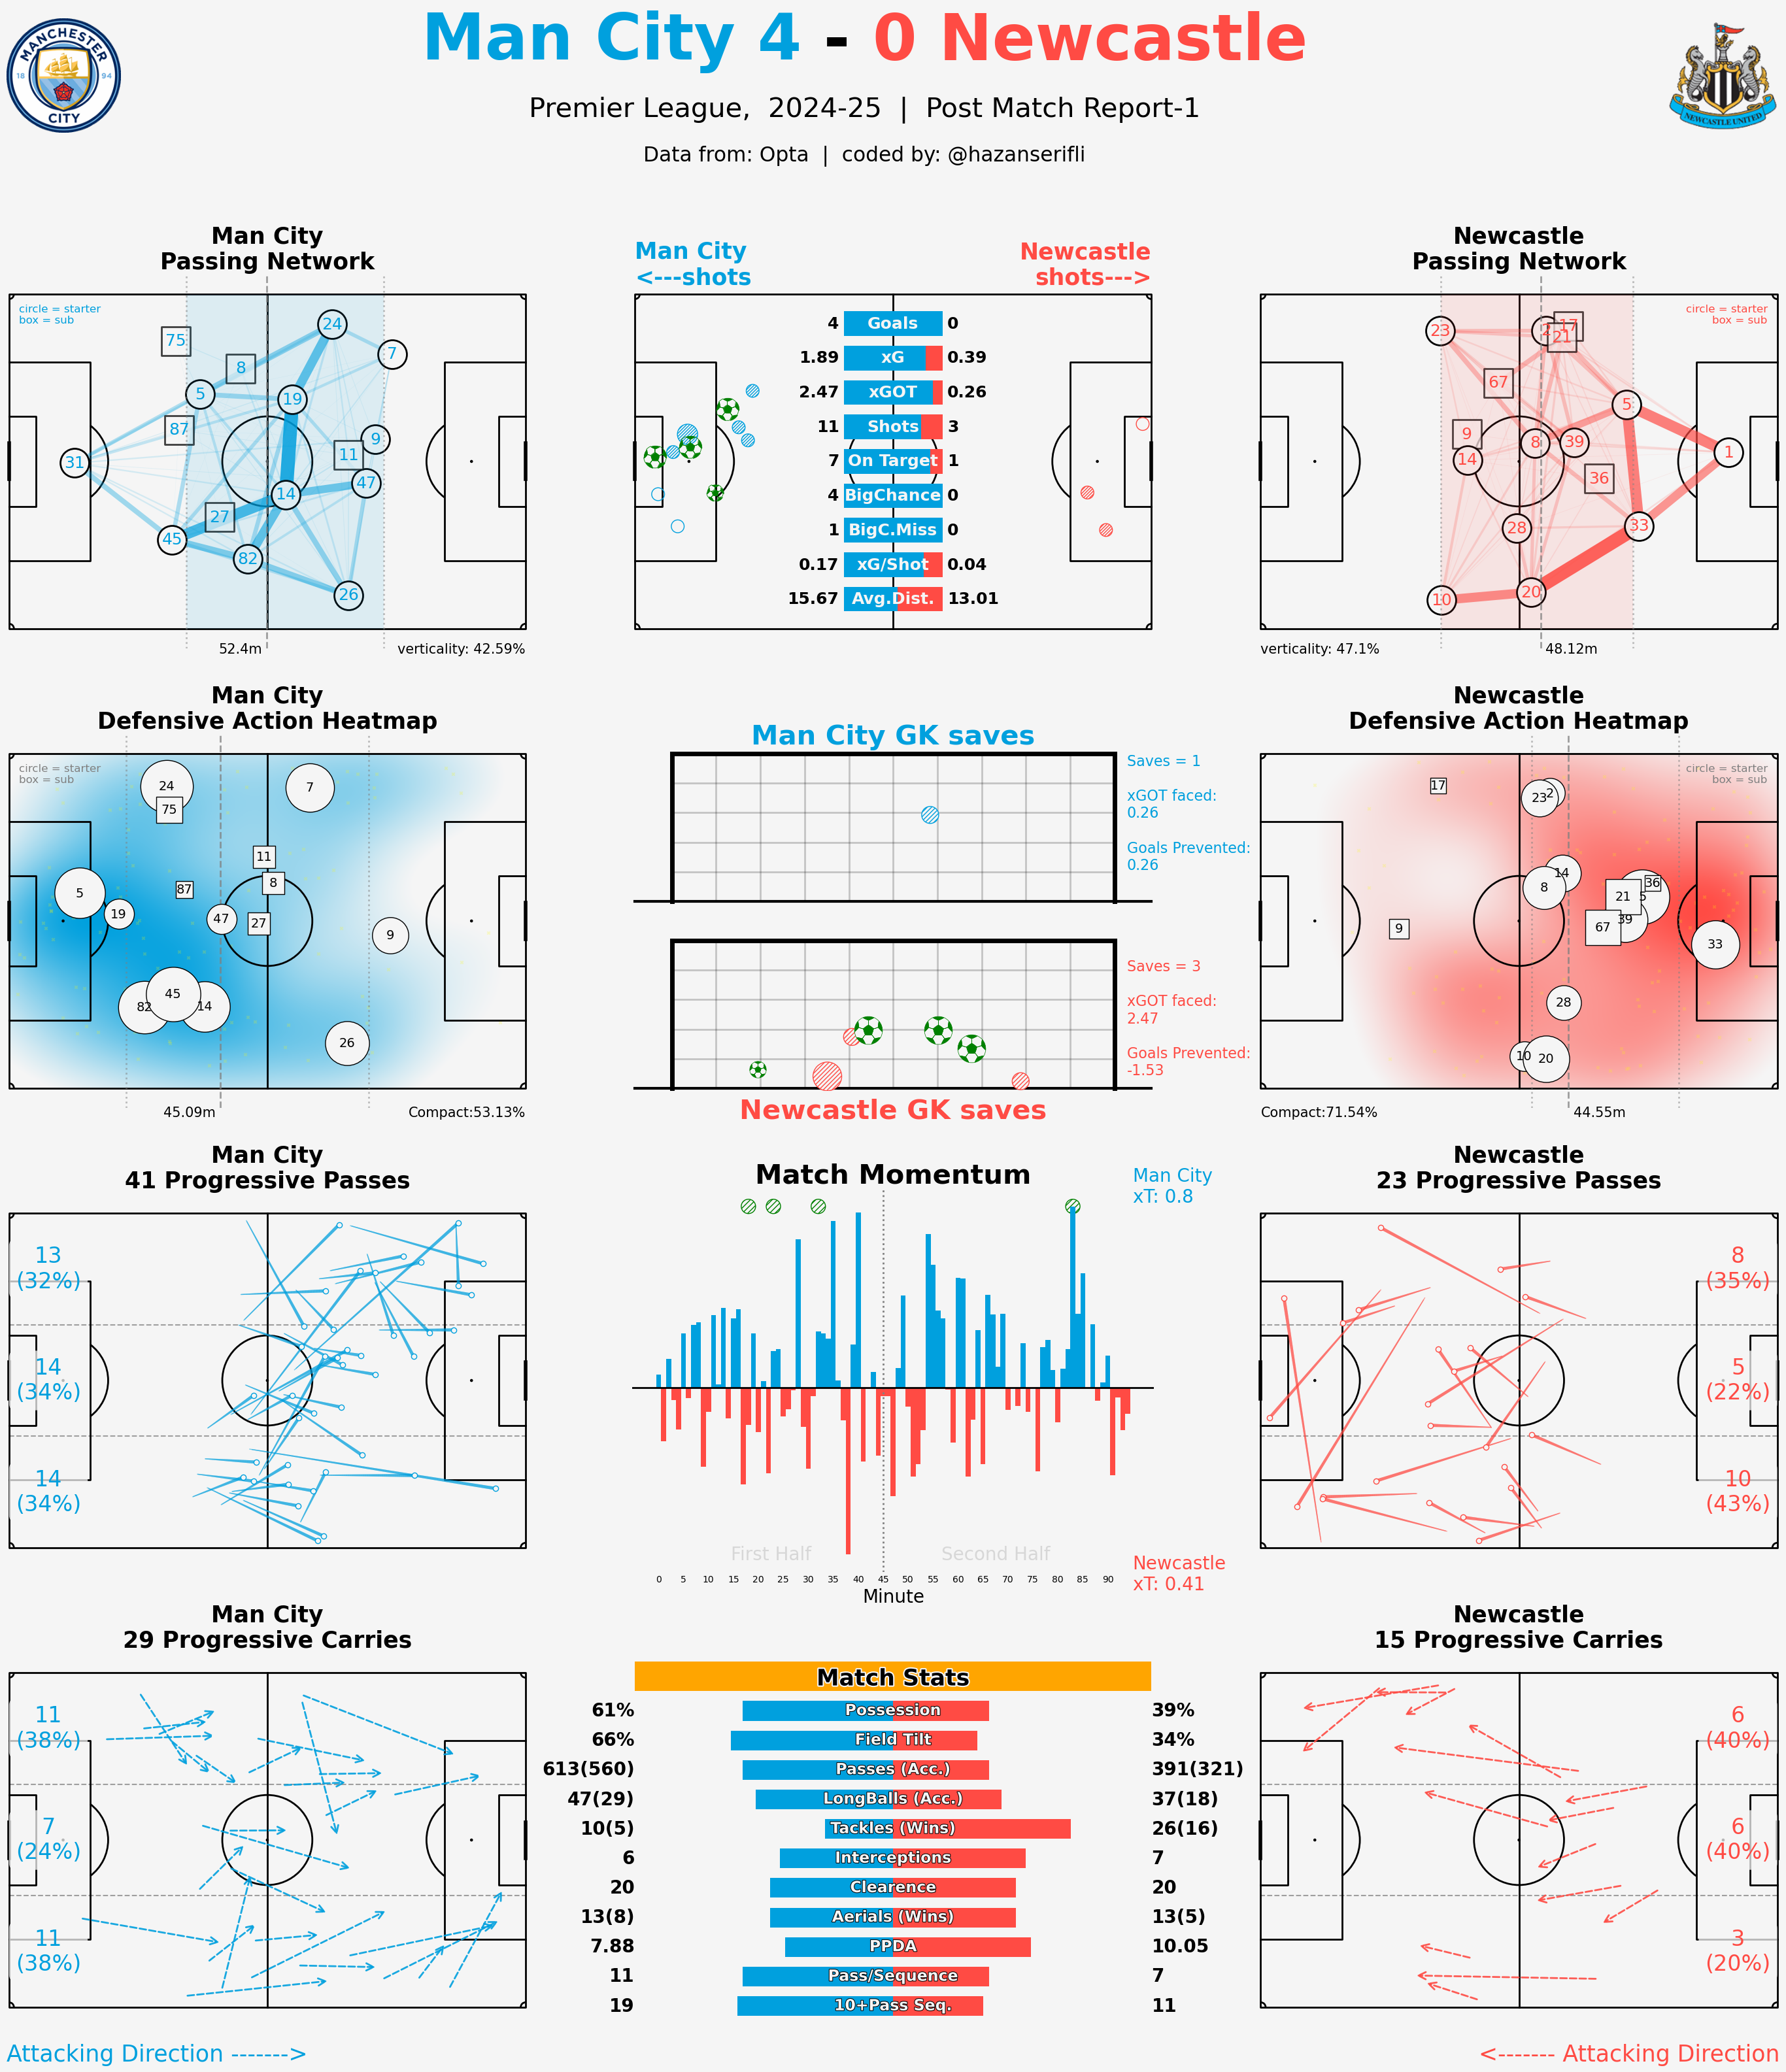

In [95]:
fig, axs = plt.subplots(4,3, figsize=(35,35), facecolor=bg_color)

pass_network_stats_home = pass_network_visualization(axs[0,0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
shooting_stats = plot_shotmap(axs[0,1])
pass_network_stats_away = pass_network_visualization(axs[0,2], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)

defensive_block_stats_home = defensive_block(axs[1,0], defensive_home_average_locs_and_count_df, hteamName, hcol)
goalkeeping_stats = plot_goalPost(axs[1,1])
defensive_block_stats_away = defensive_block(axs[1,2], defensive_away_average_locs_and_count_df, ateamName, acol)

Progressvie_Passes_Stats_home = draw_progressive_pass_map(axs[2,0], hteamName, hcol)
xT_stats = plot_Momentum(axs[2,1])
Progressvie_Passes_Stats_away = draw_progressive_pass_map(axs[2,2], ateamName, acol)

Progressvie_Carries_Stats_home = draw_progressive_carry_map(axs[3,0], hteamName, hcol)
general_match_stats = plotting_match_stats(axs[3,1])
Progressvie_Carries_Stats_away = draw_progressive_carry_map(axs[3,2], ateamName, acol)

highlight_text = [{'color':hcol}, {'color':acol}]
fig_text(0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=70, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=fig)


fig.text(0.5, 0.95, f"Premier League,  2024-25  |  Post Match Report-1", color=line_color, fontsize=30, ha='center', va='center')
fig.text(0.5, 0.93, f"Data from: Opta  |  coded by: @hazanserifli", color=line_color, fontsize=22.5, ha='center', va='center')


fig.text(0.125,0.1, 'Attacking Direction ------->', color=hcol, fontsize=25, ha='left', va='center')
fig.text(0.9,0.1, '<------- Attacking Direction', color=acol, fontsize=25, ha='right', va='center')

# Home team Logo
himage = urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{fotmob_hteam_id}.png")
himage = Image.open(himage)
ax_himage = add_image(himage, fig, left=0.125, bottom=0.94, width=0.05, height=0.05)
# Away team Logo
aimage = urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{fotmob_ateam_id}.png")
aimage = Image.open(aimage)
ax_aimage = add_image(aimage, fig, left=0.85, bottom=0.94, width=0.05, height=0.05)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4285275424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/4285275424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


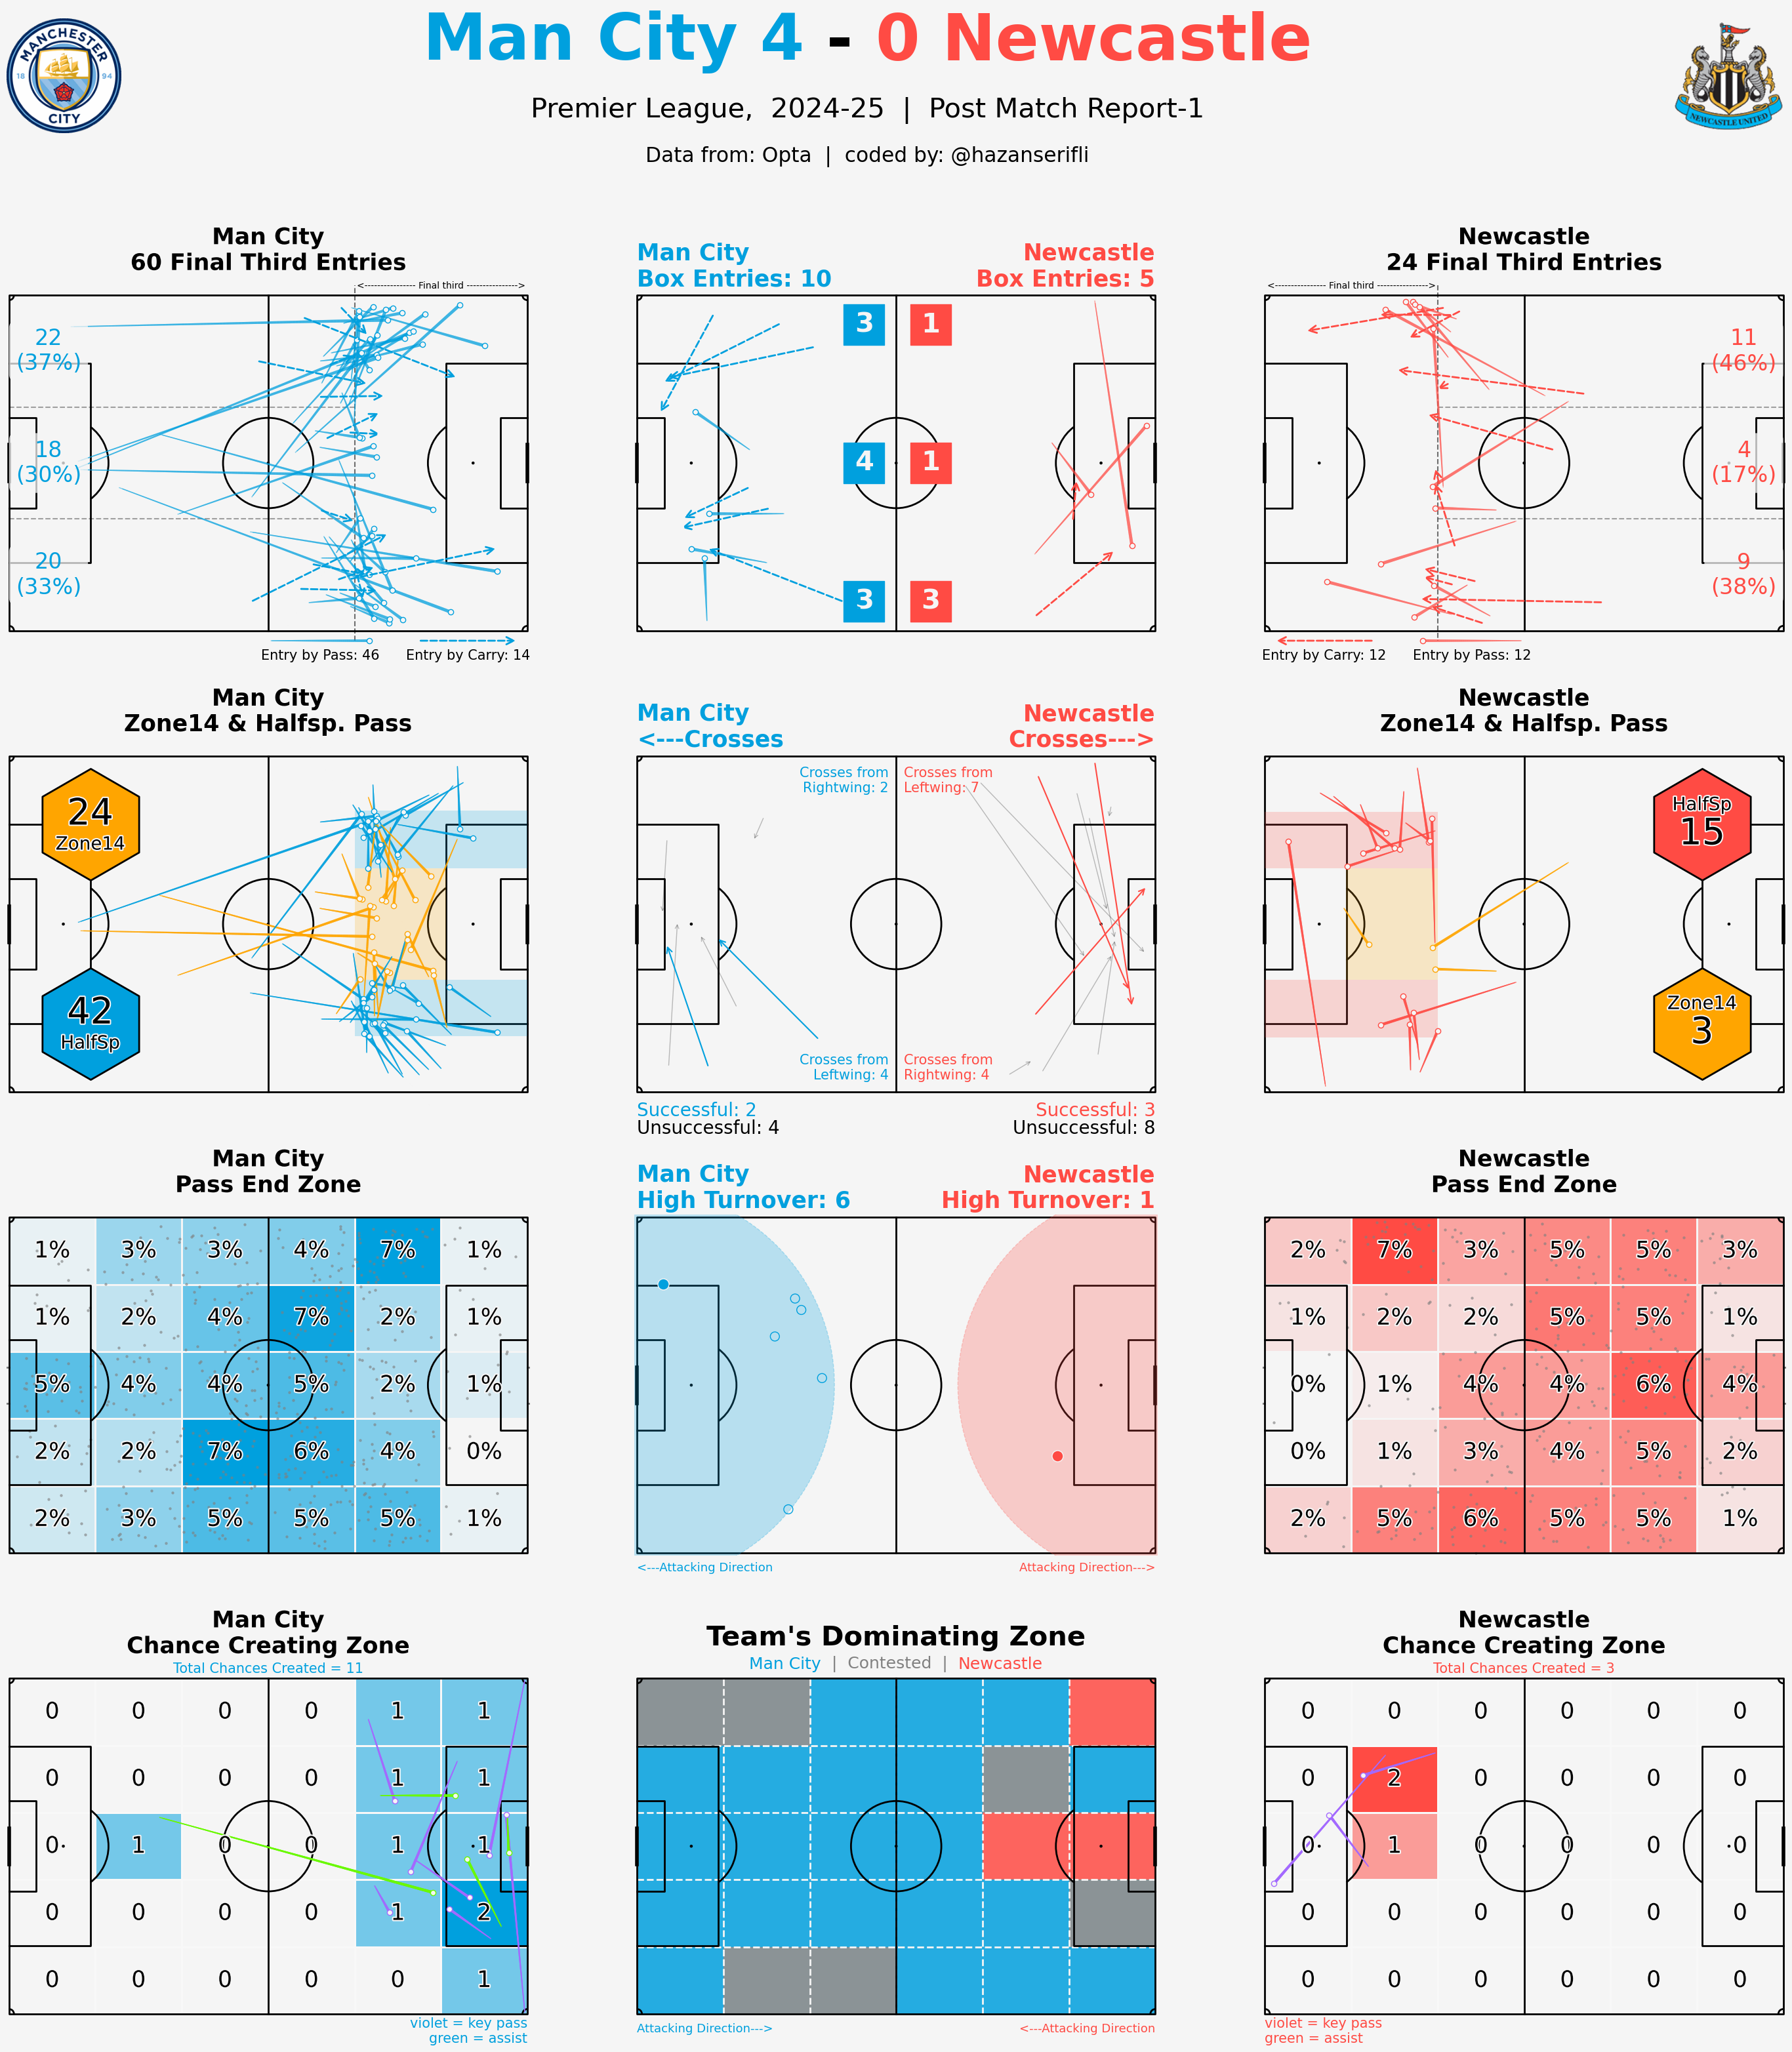

In [96]:
fig, axs = plt.subplots(4,3, figsize=(35,35), facecolor=bg_color)

final_third_entry_stats_home = Final_third_entry(axs[0,0], hteamName, hcol)
box_entry_stats = box_entry(axs[0,1])
final_third_entry_stats_away = Final_third_entry(axs[0,2], ateamName, acol)

zonal_passing_stats_home = zone14hs(axs[1,0], hteamName, hcol)
cross_stats = Crosses(axs[1,1])
zonal_passing_stats_away = zone14hs(axs[1,2], ateamName, acol)

Pass_end_zone(axs[2,0], hteamName, pearl_earring_cmaph)
high_turnover_stats = HighTO(axs[2,1])
Pass_end_zone(axs[2,2], ateamName, pearl_earring_cmapa)

chance_creating_stats_home = Chance_creating_zone(axs[3,0], hteamName, pearl_earring_cmaph, hcol)
plot_congestion(axs[3,1])
chance_creating_stats_away = Chance_creating_zone(axs[3,2], ateamName, pearl_earring_cmapa, acol)


highlight_text = [{'color':hcol}, {'color':acol}]
fig_text(0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=70, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=fig)

# font_path = "C:\Fonts\LaLiga2023Thin.otf"
# custom_font = FontProperties(fname=font_path)


fig.text(0.5, 0.95, f"Premier League,  2024-25  |  Post Match Report-1", color=line_color, fontsize=30, ha='center', va='center')
fig.text(0.5, 0.93, f"Data from: Opta  |  coded by: @hazanserifli", color=line_color, fontsize=22.5, ha='center', va='center')


# Home team Logo
himage = urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{fotmob_hteam_id}.png")
himage = Image.open(himage)
ax_himage = add_image(himage, fig, left=0.125, bottom=0.94, width=0.05, height=0.05)
# Away team Logo
aimage = urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{fotmob_ateam_id}.png")
aimage = Image.open(aimage)
ax_aimage = add_image(aimage, fig, left=0.85, bottom=0.94, width=0.05, height=0.05)


In [83]:
def individual_passMap(ax, pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']
    
    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0
    
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
                        (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Thr_ball = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Thr_ball_acc = Thr_ball[Thr_ball['outcomeType']=='Successful']
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Lng_ball_acc = Lng_ball[Lng_ball['outcomeType']=='Successful']
    Crs_pass = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Crs_pass_acc = Crs_pass[Crs_pass['outcomeType']=='Successful']
    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') & 
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') & 
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    g_assist = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) & 
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    frwd_pass = dfpass[(dfpass['pass_or_carry_angle']>= -85) & (dfpass['pass_or_carry_angle']<= 85) & 
                       (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    back_pass = dfpass[((dfpass['pass_or_carry_angle']>= 95) & (dfpass['pass_or_carry_angle']<= 180) | 
                        (dfpass['pass_or_carry_angle']>= -180) & (dfpass['pass_or_carry_angle']<= -95)) &
                       (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    side_pass = dfpass[((dfpass['pass_or_carry_angle']>= 85) & (dfpass['pass_or_carry_angle']<= 95) | 
                        (dfpass['pass_or_carry_angle']>= -95) & (dfpass['pass_or_carry_angle']<= -85)) & 
                       (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    frwd_pass_acc = frwd_pass[frwd_pass['outcomeType']=='Successful']
    back_pass_acc = back_pass[back_pass['outcomeType']=='Successful']
    side_pass_acc = side_pass[side_pass['outcomeType']=='Successful']
    corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    corners_acc = corners[corners['outcomeType']=='Successful']
    freekik = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    freekik_acc = freekik[freekik['outcomeType']=='Successful']
    thins = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    thins_acc = thins[thins['outcomeType']=='Successful']
    lngball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    lngball_acc = lngball[lngball['outcomeType']=='Successful']

    if len(frwd_pass) != 0:
        Forward_Pass_Accuracy = round((len(frwd_pass_acc)/len(frwd_pass))*100, 2)
    else:
        Forward_Pass_Accuracy = 0
    
    df_xT_inc = dfpass[dfpass['xT']>0]
    df_xT_dec = dfpass[dfpass['xT']<0]

    pitch.lines(iac_pass.x, iac_pass.y, iac_pass.endX, iac_pass.endY, color=line_color, lw=4, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color=line_color, lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(pro_pass.x, pro_pass.y, pro_pass.endX, pro_pass.endY, color=hcol      , lw=3, alpha=1,    comet=True, zorder=3, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color=violet,     lw=4, alpha=1,    comet=True, zorder=4, ax=ax)
    pitch.lines(g_assist.x, g_assist.y, g_assist.endX, g_assist.endY, color='green',      lw=4, alpha=1,    comet=True, zorder=5, ax=ax)

    ax.scatter(acc_pass.endX, acc_pass.endY, s=30, color=bg_color,    edgecolor='gray', alpha=1, zorder=2)
    ax.scatter(pro_pass.endX, pro_pass.endY, s=40, color=bg_color,  edgecolor= hcol,  alpha=1, zorder=3)
    ax.scatter(key_pass.endX, key_pass.endY, s=50, color=bg_color,  edgecolor=violet, alpha=1, zorder=4)
    ax.scatter(g_assist.endX, g_assist.endY, s=50, color=bg_color,  edgecolor= 'green', alpha=1, zorder=5)


    ax.set_title(f"PassMap", color=line_color, fontsize=25, fontweight='bold', y=1.03)
    ax_text(0, -3, f'''Accurate Pass: {len(acc_pass)}/{len(dfpass)} ({accurate_pass_perc}%) | <Progressive Pass: {len(pro_pass)}> | <Chances Created: {len(key_pass)}>
Big Chances Created: {len(big_chnc)} | <Assists: {len(g_assist)}> | Pre-Assist: {len(pre_asst)} | Build-up to Shot: {len(shot_buildup)}
Final third Passes: {len(fnl_thd)} | Passes into Penalty box: {len(pen_box)} | Crosses (Acc.): {len(Crs_pass)} ({len(Crs_pass_acc)})
Longballs (Acc.): {len(lngball)} ({len(lngball_acc)}) | xT increased from Pass: {df_xT_inc['xT'].sum().round(2)}
''', color=line_color, highlight_textprops=[{'color':hcol}, {'color':violet}, {'color':'green'}], fontsize=15, ha='left', va='top', ax=ax)
    # Open-Play Forward Pass (Acc.): {len(frwd_pass)} ({len(frwd_pass_acc)})
    # Open-Play Side Pass (Acc.): {len(side_pass)} ({len(side_pass_acc)})
    # Open-Play Back Pass (Acc.): {len(back_pass)} ({len(back_pass_acc)})
    # xT decreased as passer: {df_xT_dec['xT'].sum().round(2)}
    
    return


# fig,ax=plt.subplots(figsize=(10,10))
# individual_passMap(ax, pname)

In [84]:
def individual_carry(ax,pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5,105.5)
    ax.set_ylim(-0.5,68.5)

    df_carry = df[(df['type']=='Carry') & (df['name']==pname)]
    led_shot1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist'))]
    led_goal2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Goal')]
    led_goal = pd.concat([led_goal1, led_goal2])
    pro_carry = df_carry[(df_carry['prog_carry']>=9.11) & (df_carry['x']>=35)]
    fth_carry = df_carry[(df_carry['x']<70) & (df_carry['endX']>=70)]
    box_entry = df_carry[(df_carry['endX']>=88.5) & (df_carry['endY']>=13.6) & (df_carry['endY']<=54.4) &
                 ~((df_carry['x']>=88.5) & (df_carry['y']>=13.6) & (df_carry['y']<=54.6))]
    disp = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Dispossessed')]
    df_to = df[(df['type']=='TakeOn') & (df['name']==pname)]
    t_ons = df_to[df_to['outcomeType']=='Successful']
    t_onu = df_to[df_to['outcomeType']=='Unsuccessful']
    df_xT_inc = df_carry[df_carry['xT']>0]
    df_xT_dec = df_carry[df_carry['xT']<0]
    df_carry = df_carry.copy()
    df_carry.loc[:, 'Length'] = np.sqrt((df_carry['x'] - df_carry['endX'])**2 + (df_carry['y'] - df_carry['endY'])**2)
    median_length = round(df_carry['Length'].median(),2)
    total_length = round(df_carry['Length'].sum(),2)
    if len(df_to)!=0:
        success_rate = round((len(t_ons)/len(df_to))*100, 2)
    else:
        success_rate = 0

    for index, row in df_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), color=line_color, alpha=0.25, arrowstyle='->', linestyle='--', 
                                   linewidth=2, mutation_scale=15, zorder=2)
        ax.add_patch(arrow)
    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), color=hcol, alpha=1, arrowstyle='->', linestyle='--', linewidth=3, 
                                   mutation_scale=20, zorder=3)
        ax.add_patch(arrow)
    for index, row in led_shot.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), color=violet, alpha=1, arrowstyle='->', linestyle='--', linewidth=4, 
                                   mutation_scale=20, zorder=4)
        ax.add_patch(arrow)
    for index, row in led_goal.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), color='green', alpha=1, arrowstyle='->', linestyle='--', linewidth=4, 
                                   mutation_scale=20, zorder=4)
        ax.add_patch(arrow)

    ax.scatter(t_ons.x, t_ons.y, s=250, color='orange', edgecolor=line_color, lw=2, zorder=5)
    ax.scatter(t_onu.x, t_onu.y, s=250, color='None', edgecolor='orange', hatch='/////', lw=2.5, zorder=5)

    ax.set_title(f"Carries & TakeOns", color='k', fontsize=25, fontweight='bold', y=1.03)
    ax_text(0, -3, f'''Total Carries: {len(df_carry)} | <Progressive Carries: {len(pro_carry)}> | <Carries Led to Shot: {len(led_shot)}>
<Carries Led to Goal: {len(led_goal)}> | Carrier Dispossessed: {len(disp)} | Carries into Final third: {len(fth_carry)}
Carries into pen.box: {len(box_entry)} | Avg. Carry Length: {median_length} m | Total Carry: {total_length} m
xT increased from Carries: {df_xT_inc['xT'].sum().round(2)} | <Successful TakeOns: {len(t_ons)}/{len(df_to)} ({success_rate}%)>
''', highlight_textprops=[{'color':hcol}, {'color':violet}, {'color':'green'}, {'color':'darkorange'}], fontsize=15, ha='left', 
            va='top', ax=ax)
    # xT decreased as carrier: {df_xT_dec['xT'].sum().round(2)}
    return

# fig,ax=plt.subplots(figsize=(10,10))
# individual_carry(ax, pname)

In [85]:
def Individual_ShotMap(ax, pname):
    """
    Creates a shot map for a given player and displays shooting stats.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to draw the pitch and shots on.
        pname (str): The name of the player to analyze.
    """
    # Set up the pitch
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    # Filter shots for the player
    player_shots = shots_df[(shots_df['playerName'] == pname) & (shots_df['isOwnGoal'] == 0)]

    # Categorize shots
    goal = player_shots[player_shots['eventType'] == 'Goal']
    miss = player_shots[player_shots['eventType'] == 'Miss']
    save = player_shots[(player_shots['eventType'] == 'AttemptSaved') & (player_shots['isBlocked'] == 0)]
    blok = player_shots[(player_shots['eventType'] == 'AttemptSaved') & (player_shots['isBlocked'] == 1)]
    post = player_shots[player_shots['eventType'] == 'Post']

    # Check if 'isBigChance' column exists
    if 'isBigChance' in player_shots.columns:
        # Filter big chances if the column exists
        big_chances = player_shots[player_shots['isBigChance'] == 1]
        goal_bc = big_chances[big_chances['eventType'] == 'Goal']
        miss_bc = big_chances[big_chances['eventType'] == 'Miss']
        save_bc = big_chances[big_chances['eventType'] == 'AttemptSaved']
        post_bc = big_chances[big_chances['eventType'] == 'Post']
    else:
        # If 'isBigChance' column doesn't exist, assume no big chances
        goal_bc = pd.DataFrame()
        miss_bc = pd.DataFrame()
        save_bc = pd.DataFrame()
        post_bc = pd.DataFrame()

    # Calculate total shots and average distance
    total_shots = len(player_shots)
    open_play_shots = len(player_shots[player_shots['situation'].str.contains('RegularPlay|FastBreak|IndividualPlay')])
    shots_outside_box = len(player_shots[player_shots['situation'].str.contains('OutOfBox')])
    shots_inside_box = total_shots - shots_outside_box

    # Calculate average shot distance
    player_shots.loc[:, 'Length'] = np.sqrt((player_shots['x'] - 105)**2 + (player_shots['y'] - 34)**2)
    avg_dist = round(player_shots['Length'].mean(), 2)

    # Calculate xG and xGOT
    xG = player_shots['expectedGoals'].sum().round(2)
    xGOT = player_shots['expectedGoalsOnTarget'].sum().round(2)

    # Plot shots on the pitch
    pitch.scatter(goal.x, goal.y, s=goal['expectedGoals'] * 1000 + 100, marker='football', c='None', edgecolors='green', zorder=5, ax=ax)
    pitch.scatter(post.x, post.y, s=post['expectedGoals'] * 1000 + 100, marker='o', c='None', edgecolors=hcol, hatch='+++', zorder=4, ax=ax)
    pitch.scatter(blok.x, blok.y, s=blok['expectedGoals'] * 1000 + 100, marker='o', c='None', edgecolors=hcol, hatch='/////', zorder=4, ax=ax)
    pitch.scatter(save.x, save.y, s=save['expectedGoals'] * 1000 + 100, marker='o', c=hcol, edgecolors=line_color, zorder=3, ax=ax)
    pitch.scatter(miss.x, miss.y, s=miss['expectedGoals'] * 1000 + 100, marker='o', c='None', edgecolors=hcol, zorder=2, ax=ax)

    # Add legend for shot types
    pitch.scatter(2, 56 - (0 * 4), s=200, marker='football', c='None', edgecolors='green', zorder=5, ax=ax)
    pitch.scatter(2, 56 - (1 * 4), s=150, marker='o', c='None', edgecolors=hcol, hatch='+++', zorder=4, ax=ax)
    pitch.scatter(2, 56 - (2 * 4), s=150, marker='o', c=hcol, edgecolors=line_color, zorder=3, ax=ax)
    pitch.scatter(2, 56 - (3 * 4), s=130, marker='o', c='None', edgecolors=hcol, zorder=2, ax=ax)
    pitch.scatter(2, 56 - (4 * 4), s=130, marker='o', c='None', edgecolors=hcol, hatch='/////', zorder=2, ax=ax)

    # Add shooting stats text
    ax.text(0, 71, "Shooting Stats", color=line_color, fontsize=25, fontweight='bold')
    ax.text(7, 64 - (0 * 4), f'Total Shots: {total_shots}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (1 * 4), f'Open-play Shots: {open_play_shots}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (2 * 4), f'Goals: {len(goal)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (3 * 4), f'Shot on Post: {len(post)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (4 * 4), f'Shots on Target: {len(goal) + len(save)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (5 * 4), f'Shots off Target: {len(miss)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (6 * 4), f'Shots Blocked: {len(blok)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (7 * 4), f'Big Chances: {len(goal_bc) + len(miss_bc) + len(save_bc) + len(post_bc)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (8 * 4), f'Big Chances Missed: {len(miss_bc) + len(save_bc) + len(post_bc)}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (9 * 4), f'Shots outside box: {shots_outside_box}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (10 * 4), f'Shots inside box: {shots_inside_box}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (11 * 4), f'Avg. Shot Distance: {avg_dist} m', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (12 * 4), f'xG: {xG}', fontsize=15, ha='left', va='center')
    ax.text(7, 64 - (13 * 4), f'xGOT: {xGOT}', fontsize=15, ha='left', va='center')

    # Add title for the shot map
    ax.text(80, 71, "Shot Map", color=line_color, fontsize=25, fontweight='bold', ha='center')

    return

In [86]:
def individual_passes_recieved(ax, pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    
    dfp = df[(df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['name'].shift(-1)==pname)]
    dfkp = dfp[dfp['qualifiers'].str.contains('KeyPass')]
    dfas = dfp[dfp['qualifiers'].str.contains('IntentionalGoalAssist')]
    dfnt = dfp[dfp['endX']>=70]
    dfpen = dfp[(dfp['endX']>=87.5) & (dfp['endY']>=13.6) & (dfp['endY']<=54.6)]
    dfpro = dfp[(dfp['x']>=35) & (dfp['prog_pass']>=9.11) & (~dfp['qualifiers'].str.contains('CornerTaken|Frerkick'))]
    dfcros = dfp[(dfp['qualifiers'].str.contains('Cross')) & (~dfp['qualifiers'].str.contains('CornerTaken|Frerkick'))]
    dfxT = dfp[dfp['xT']>=0]
    dflb = dfp[(dfp['qualifiers'].str.contains('Longball'))]
    cutback = dfp[((dfp['x'] >= 88.54) & (dfp['x'] <= 105) & 
                       ((dfp['y'] >= 40.8) & (dfp['y'] <= 54.4) | (dfp['y'] >= 13.6) & (dfp['y'] <= 27.2)) & 
                       (dfp['endY'] >= 27.2) & (dfp['endY'] <= 40.8) & (dfp['endX'] >= 81.67))]
    next_act = df[(df['name']==pname) & (df['type'].shift(1)=='Pass') & (df['outcomeType'].shift(1)=='Successful')]
    ball_retain = next_act[(next_act['outcomeType']=='Successful') & ((next_act['type']!='Foul') & (next_act['type']!='Dispossessed'))]
    if len(next_act) != 0:
        ball_retention = round((len(ball_retain)/len(next_act))*100, 2)
    else:
        ball_retention = 0

    if len(dfp) != 0:
        name_counts = dfp['shortName'].value_counts()
        name_counts_df = name_counts.reset_index()
        name_counts_df.columns = ['name', 'count']
        name_counts_df = name_counts_df.sort_values(by='count', ascending=False)  
        name_counts_df = name_counts_df.reset_index()
        r_name = name_counts_df['name'][0]
        r_count = name_counts_df['count'][0]
    else:
        r_name = 'None'
        r_count = 0        

    pitch.lines(dfp.x, dfp.y, dfp.endX, dfp.endY, lw=3, transparent=True, comet=True,color=hcol, ax=ax, alpha=0.5)
    pitch.lines(dfkp.x, dfkp.y, dfkp.endX, dfkp.endY, lw=4, transparent=True, comet=True,color=violet, ax=ax, alpha=0.75)
    pitch.lines(dfas.x, dfas.y, dfas.endX, dfas.endY, lw=4, transparent=True, comet=True,color='green', ax=ax, alpha=0.75)
    pitch.scatter(dfp.endX, dfp.endY, s=30, edgecolor=hcol, linewidth=1, color=bg_color, zorder=2, ax=ax)
    pitch.scatter(dfkp.endX, dfkp.endY, s=40, edgecolor=violet, linewidth=1.5, color=bg_color, zorder=2, ax=ax)
    pitch.scatter(dfas.endX, dfas.endY, s=50, edgecolors='green', linewidths=1, marker='football', c=bg_color, zorder=2, ax=ax)

    avg_endY = dfp['endY'].median()
    avg_endX = dfp['endX'].median()
    ax.axvline(x=avg_endX, ymin=0, ymax=68, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.axhline(y=avg_endY, xmin=0, xmax=105, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.set_title(f"Passes Recieved", color=line_color, fontsize=25, fontweight='bold', y=1.03)
    ax_text(0, -3, f'''<Passes Received: {len(dfp)}> | <Key Passes Received: {len(dfkp)}> | <Assists Received: {len(dfas)}>
Passes Received in Final third: {len(dfnt)} | Passes Received in Opponent box: {len(dfpen)}
Progressive Passes Received: {len(dfpro)} | Crosses Received: {len(dfcros)} | Longballs Received: {len(dflb)}
Cutbacks Received: {len(cutback)} | Ball Retention: {ball_retention} % | xT Received: {dfxT['xT'].sum().round(2)}
Avg. Distance of Pass Receiving from Opponent Goal line: {round(105-dfp['endX'].median(),2)}m
Most Passes from: {r_name} ({r_count})''', fontsize=15, ha='left', va='top', ax=ax,
           highlight_textprops=[{'color':hcol}, {'color':violet}, {'color':'green'}])

    return

# fig,ax=plt.subplots(figsize=(10,10))
# individual_passes_recieved(ax, pname)

In [87]:
def individual_def_acts(ax, pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, line_zorder=2, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5,68.5)

    playerdf = df[(df['name']==pname)]
    ball_wins = playerdf[(playerdf['type']=='Interception') | (playerdf['type']=='BallRecovery')]
    f_third = ball_wins[ball_wins['x']>=70]
    m_third = ball_wins[(ball_wins['x']>35) & (ball_wins['x']<70)]
    d_third = ball_wins[ball_wins['x']<=35]

    hp_tk = playerdf[(playerdf['type']=='Tackle')]
    hp_tk_u = playerdf[(playerdf['type']=='Tackle') & (playerdf['outcomeType']=='Unsuccessful')]
    hp_intc = playerdf[(playerdf['type']=='Interception')]
    hp_br = playerdf[playerdf['type']=='BallRecovery']
    hp_cl = playerdf[playerdf['type']=='Clearance']
    hp_fl = playerdf[playerdf['type']=='Foul']
    hp_ar = playerdf[(playerdf['type']=='Aerial') & (playerdf['qualifiers'].str.contains('Defensive'))]
    hp_ar_u = playerdf[(playerdf['type']=='Aerial') & (playerdf['outcomeType']=='Unsuccessful') & (playerdf['qualifiers'].str.contains('Defensive'))]
    pass_bl = playerdf[playerdf['type']=='BlockedPass']
    shot_bl = playerdf[playerdf['type']=='Save']
    drb_pst = playerdf[playerdf['type']=='Challenge']
    drb_tkl = df[(df['name']==pname) & (df['type']=='Tackle') & (df['type'].shift(1)=='TakeOn') & (df['outcomeType'].shift(1)=='Unsuccessful')]
    err_lat = playerdf[playerdf['qualifiers'].str.contains('LeadingToAttempt')]
    err_lgl = playerdf[playerdf['qualifiers'].str.contains('LeadingToGoal')]
    dan_frk = playerdf[(playerdf['type']=='Foul') & (playerdf['x']>16.5) & (playerdf['x']<35) & (playerdf['y']>13.6) & (playerdf['y']<54.4)]
    prbr = df[(df['name']==pname) & ((df['type']=='BallRecovery') | (df['type']=='Interception')) & (df['name'].shift(-1)==pname) & 
              (df['outcomeType'].shift(-1)=='Successful') &
              ((df['type'].shift(-1)!='Foul') | (df['type'].shift(-1)!='Dispossessed'))]
    if (len(hp_br)+len(hp_intc)) != 0:
        post_rec_ball_retention = round((len(prbr)/(len(hp_br)+len(hp_intc)))*100, 2)
    else:
        post_rec_ball_retention = 0

    pitch.scatter(hp_tk.x, hp_tk.y, s=250, c=hcol, lw=2.5, edgecolor=hcol, marker='+', hatch='/////', ax=ax)
    pitch.scatter(hp_tk_u.x, hp_tk_u.y, s=250, c='gray', lw=2.5, edgecolor='gray', marker='+', hatch='/////', ax=ax)
    pitch.scatter(hp_intc.x, hp_intc.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='s', hatch='/////', ax=ax)
    pitch.scatter(hp_br.x, hp_br.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='o', hatch='/////', ax=ax)
    pitch.scatter(hp_cl.x, hp_cl.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='d', hatch='/////', ax=ax)
    pitch.scatter(hp_fl.x, hp_fl.y, s=250, c=hcol, lw=2.5, edgecolor=hcol, marker='x', hatch='/////', ax=ax)
    pitch.scatter(hp_ar.x, hp_ar.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='^', hatch='/////', ax=ax)
    pitch.scatter(hp_ar_u.x, hp_ar_u.y, s=250, c='None', lw=2.5, edgecolor='gray', marker='^', hatch='/////', ax=ax)
    pitch.scatter(drb_pst.x, drb_pst.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='h', hatch='|||||', ax=ax)

    ax.set_title(f"Defensive Actions", color=line_color, fontsize=25, fontweight='bold', y=1.03)
    ax_text(0, -3, f'''Tackle (Win): {len(hp_tk)} ({len(hp_tk) - len(hp_tk_u)}) | Dribblers Tackled: {len(drb_tkl)} | Dribble past: {len(drb_pst)} | Interception: {len(hp_intc)}
Ball Recovery: {len(hp_br)} | Post Recovery Ball Retention: {post_rec_ball_retention} %  | Pass Block: {len(pass_bl)}
Ball Clearances: {len(hp_cl)} | Shots Blocked: {len(shot_bl)} | Aerial Duels (Win): {len(hp_ar)} ({len(hp_ar) - len(hp_ar_u)}) | Fouls: {len(hp_fl)}
Fouls infront of Penalty Box: {len(dan_frk)} | Error Led to Shot/Led to Goal: {len(err_lat)}/{len(err_lgl)}
Possession Win in Final third/Mid third/Defensive third: {len(f_third)}/{len(m_third)}/{len(d_third)}
''', fontsize=15, ha='left', va='top', ax=ax)
    return

# fig,ax=plt.subplots(figsize=(10,10))
# individual_def_acts(ax, pname)

In [88]:
def heatMap(ax,pname):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=3)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5,105.5)
    ax.set_ylim(-0.5,68.5) 

    df_player = df[df['name']==pname]
    df_player = df_player[~df_player['type'].str.contains('SubstitutionOff|SubstitutionOn|Card|Carry')]
    new_data = pd.DataFrame({'x': [-5, -5, 110, 110], 'y': [-5, 73, 73, -5]})
    df_player = pd.concat([df_player, new_data], ignore_index=True)
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [bg_color, green, 'yellow', hcol, 'red'], N=500)
    # Create heatmap
    # pitch.kdeplot(df_player.x, df_player.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)
    
    heatmap, xedges, yedges = np.histogram2d(df_player.x, df_player.y, bins=(12,12))
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    # extent = [0,105,68,0]
    ax.imshow(heatmap.T, extent=extent, cmap=flamingo_cmap, interpolation='bilinear')

    touches = df_player[df_player['isTouch']==1]
    final_third = touches[touches['x']>=70]
    pen_box = touches[(touches['x']>=88.5) & (touches['y']>=13.6) & (touches['y']<=54.4)]

    ax.scatter(touches.x, touches.y, marker='o', s=10, c='gray')

    points = touches[['x', 'y']].values
    hull = ConvexHull(points)
    # # Plotting the convex hull
    # ax.plot(points[:,0], points[:,1], 'o')
    # for simplex in hull.simplices:
    #     ax.plot(points[simplex, 0], points[simplex, 1], 'k-')
    # ax.fill(points[hull.vertices,0], points[hull.vertices,1], 'c', alpha=0.3)
    area_covered = round(hull.volume,2)
    area_perc = round((area_covered/(105*68))*100, 2)

    df_player = df[df['name']==pname]
    df_player = df_player[~df_player['type'].str.contains('CornerTaken|FreekickTaken|Card|CornerAwarded|SubstitutionOff|SubstitutionOn')]
    df_player = df_player[['x', 'y', 'period']]
    dfp_fh = df_player[df_player['period']=='FirstHalf']
    dfp_sh = df_player[df_player['period']=='SecondHalf']
    dfp_fpet = df_player[df_player['period']=='FirstPeriodOfExtraTime']
    dfp_spet = df_player[df_player['period']=='SecondPeriodOfExtraTime']
    
    dfp_fh['distance_covered'] = np.sqrt((dfp_fh['x'] - dfp_fh['x'].shift(-1))**2 + (dfp_fh['y'] - dfp_fh['y'].shift(-1))**2)
    dist_cov_fh = (dfp_fh['distance_covered'].sum()/1000).round(2)
    dfp_sh['distance_covered'] = np.sqrt((dfp_sh['x'] - dfp_sh['x'].shift(-1))**2 + (dfp_sh['y'] - dfp_sh['y'].shift(-1))**2)
    dist_cov_sh = (dfp_sh['distance_covered'].sum()/1000).round(2)
    dfp_fpet['distance_covered'] = np.sqrt((dfp_fpet['x'] - dfp_fpet['x'].shift(-1))**2 + (dfp_fpet['y'] - dfp_fpet['y'].shift(-1))**2)
    dist_cov_fpet = (dfp_fpet['distance_covered'].sum()/1000).round(2)
    dfp_spet['distance_covered'] = np.sqrt((dfp_spet['x'] - dfp_spet['x'].shift(-1))**2 + (dfp_spet['y'] - dfp_spet['y'].shift(-1))**2)
    dist_cov_spet = (dfp_spet['distance_covered'].sum()/1000).round(2)
    tot_dist_cov = dist_cov_fh + dist_cov_sh + dist_cov_fpet + dist_cov_spet

    ax.set_title(f"Touches and Heatmap", color=line_color, fontsize=25, fontweight='bold', y=1.03)
    ax.text(52.5, -3, f'''Touches: {len(touches)}  |  Touches in Final third: {len(final_third)}  |  Touches in Penalty Area: {len(pen_box)}
    Total Distances Covered: {round(tot_dist_cov,2)} Km
    Total Area Covered: {area_covered} sq.m ({area_perc}% of the Total Field Area)
    ''',
            fontsize=15, ha='center', va='top')

    return

# fig,ax=plt.subplots(figsize=(10,10))
# heatMap(ax, pname)

In [89]:
def playing_time(pname):
    df_player = df[df['name']==pname]
    df_player['isFirstEleven'] = df_player['isFirstEleven'].fillna(0)
    df_sub_off = df_player[df_player['type']=='SubstitutionOff']
    df_sub_on  = df_player[df_player['type']=='SubstitutionOn']
    max_min = df['minute'].max()
    extra_time = max_min - 90
    if df_player['isFirstEleven'].unique() == 1 and len(df_sub_off)==0:
        mins_played = 90
    elif df_player['isFirstEleven'].unique() == 1 and len(df_sub_off)==1:
        acc_mins_played = int(df_sub_off['minute'].unique())
        if acc_mins_played > 90:
            mins_played = int((acc_mins_played*90)/max_min)
        else:
            mins_played = acc_mins_played
    elif df_player['isFirstEleven'].unique()==0:
        mins_played = int(max_min - df_sub_on['minute'].unique() - extra_time)
    else:
        mins_played = 0

    return int(mins_played)

In [90]:
df['name'].unique()

array(['nan', 'Phil Foden', 'Nico Gonzalez', 'Ederson', 'John Stones',
       'Rico Lewis', 'Ilkay Gundogan', 'Savinho', 'Joe Willock',
       'Abdukodir Khusanov', 'Sandro Tonali', 'Josko Gvardiol',
       'Erling Haaland', 'Fabian Schar', 'Omar Marmoush',
       'Bruno Guimaraes', 'Kieran Trippier', 'Alexander Isak',
       'Martin Dubravka', 'Lewis Hall', 'Anthony Gordon', 'Dan Burn',
       'Jacob Murphy', 'Tino Livramento', 'Lewis Miley', 'Sean Longstaff',
       'Callum Wilson', 'Jeremy Doku', 'James McAtee', 'Mateo Kovacic',
       "Nico O'Reilly", 'Matheus Nunes', 'Emil Krafth'], dtype=object)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/2364941696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player['isFirstEleven'] = df_player['isFirstEleven'].fillna(0)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/2364941696.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acc_mins_played = int(df_sub_off['minute'].unique())
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_2147/377927183.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

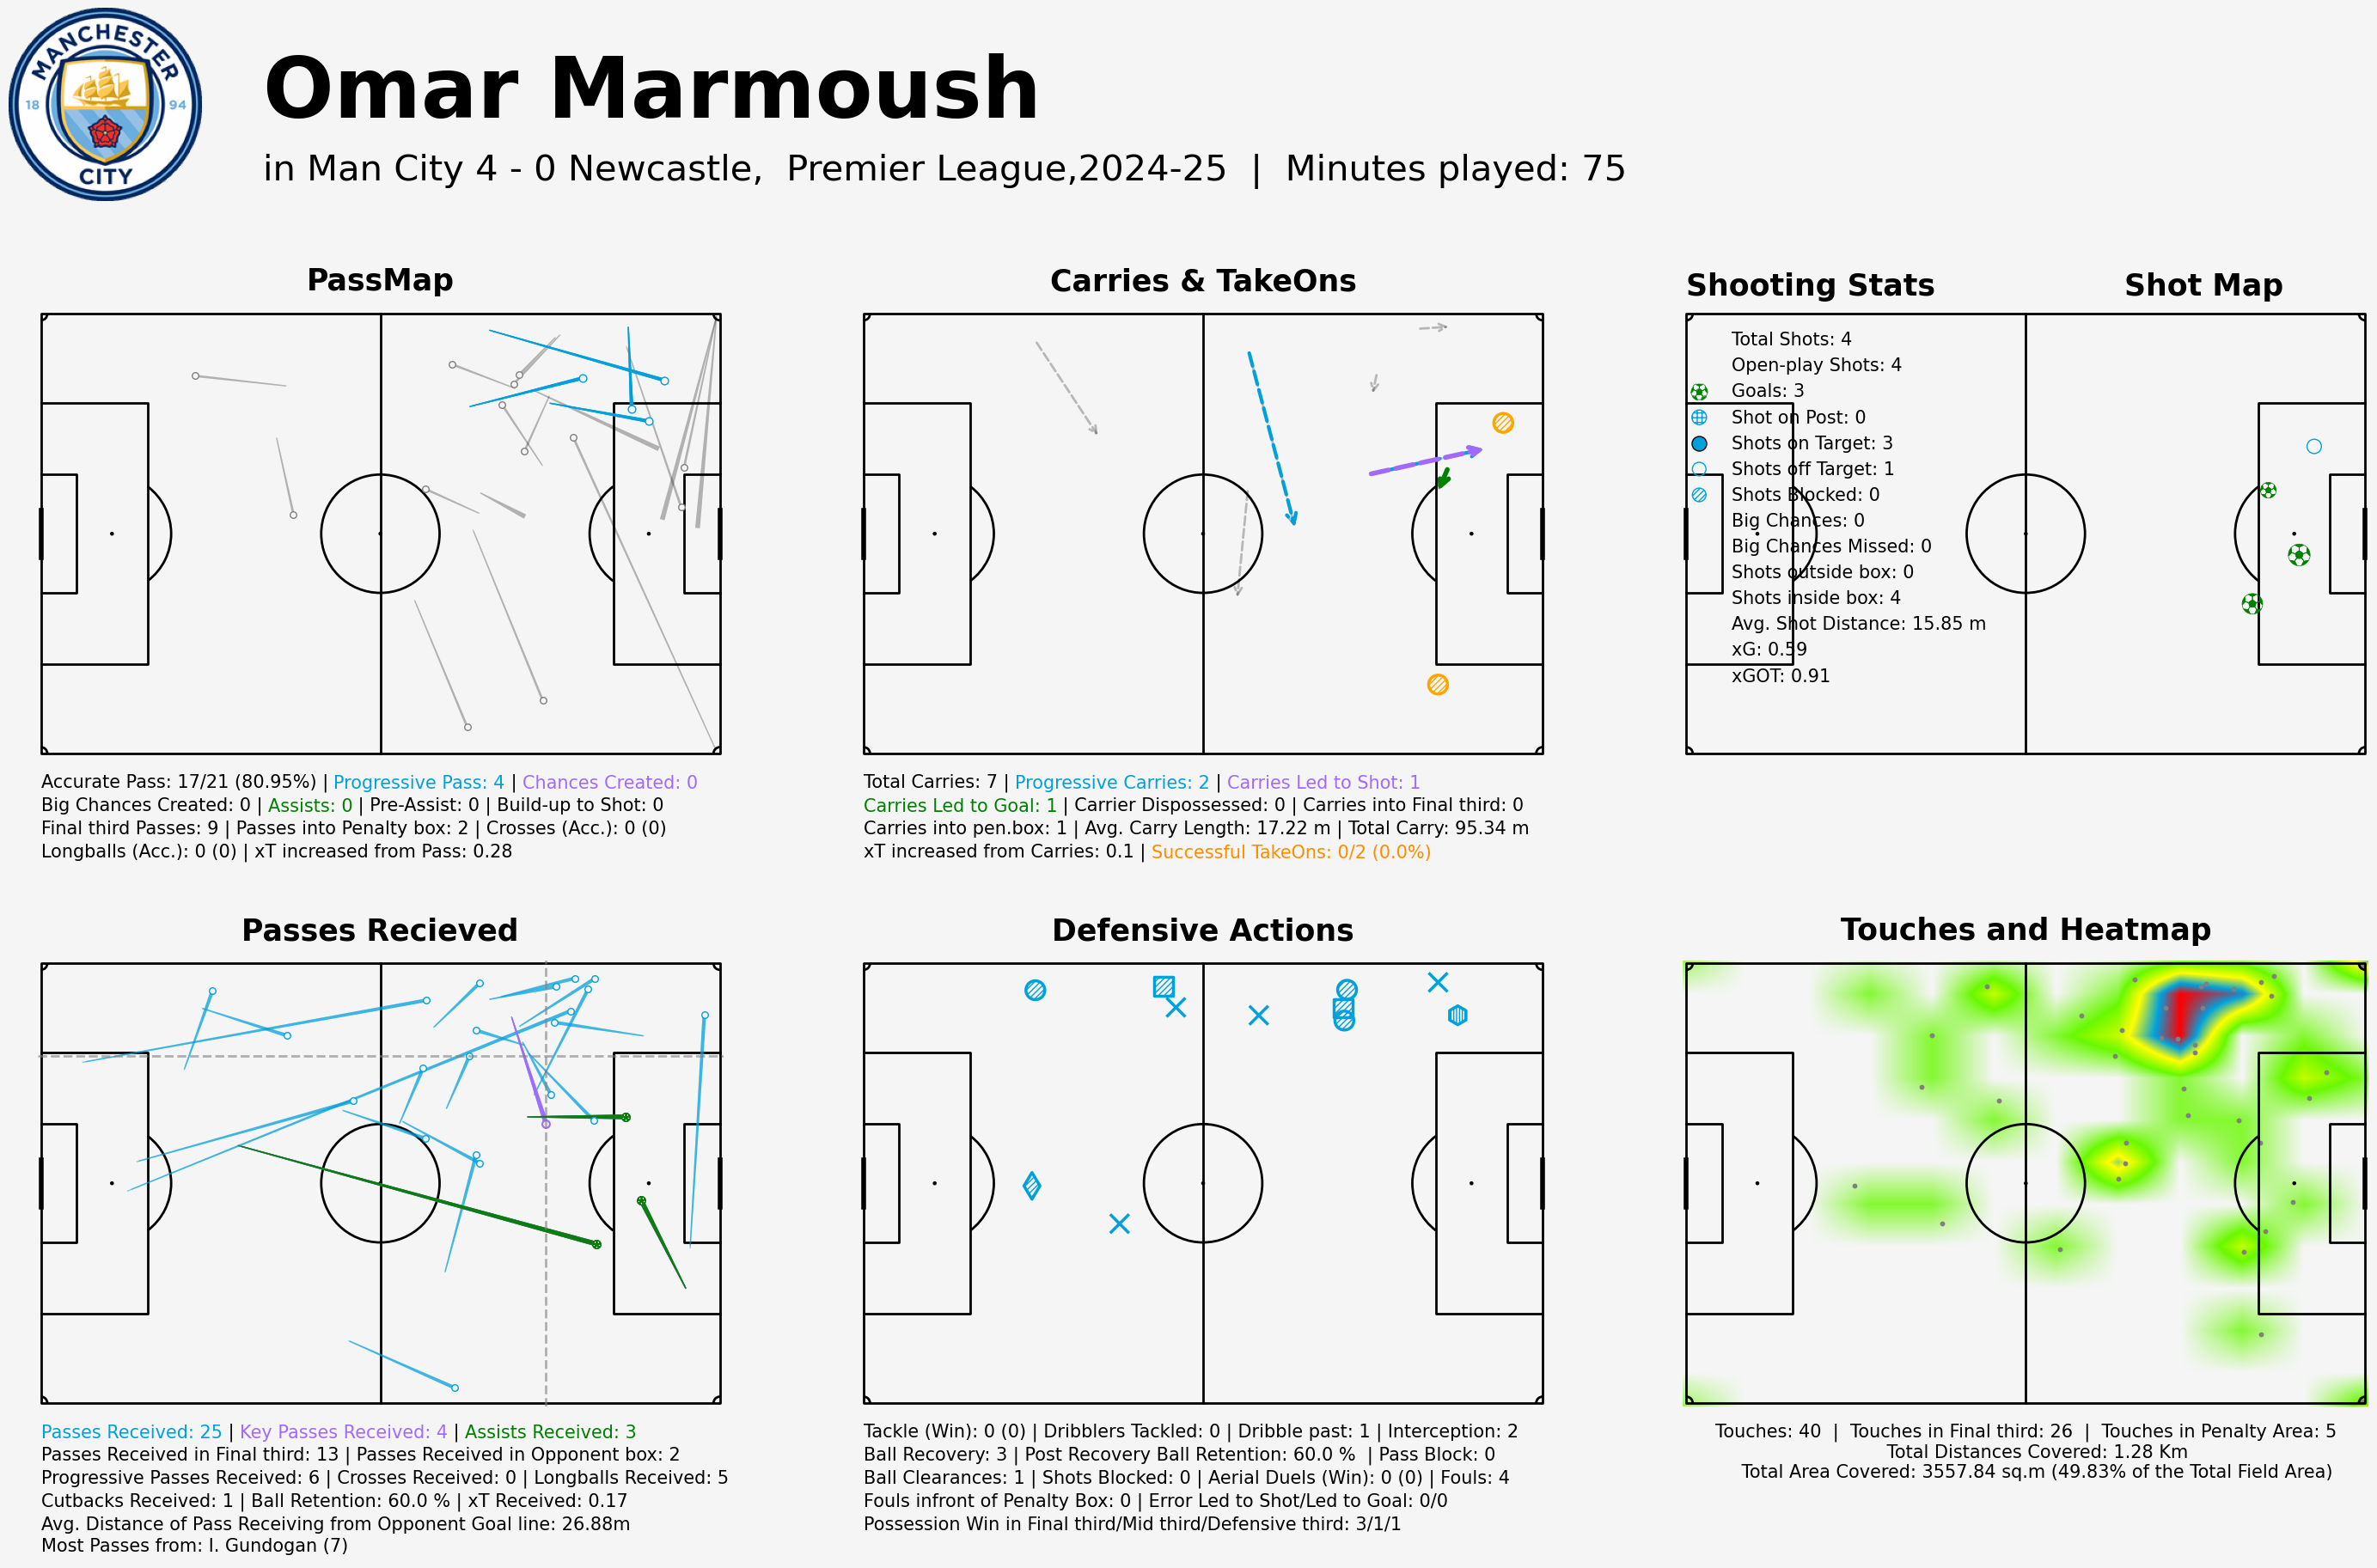

In [91]:
def generate_and_save_figure(pname, team_name, ftmb_tid):
    fig, axs = plt.subplots(2, 3, figsize=(35, 18), facecolor='#f5f5f5')
    
    # Calculate minutes played
    mins_played = playing_time(pname)
    
    # Generate individual plots
    individual_passMap(axs[0, 0], pname)
    individual_carry(axs[0, 1], pname)
    
    individual_passes_recieved(axs[1, 0], pname)
    individual_def_acts(axs[1, 1], pname)
    heatMap(axs[1, 2], pname)
    Individual_ShotMap(axs[0, 2], pname)
    
    # Add text and images to the figure
    fig.text(0.2, 0.99, f'{pname}', fontsize=70, fontweight='bold', ha='left', va='center')
    fig.text(0.2, 0.94, f'in {hteamName} {hgoal_count} - {agoal_count} {ateamName},  Premier League,2024-25  |  Minutes played: {mins_played}', 
             fontsize=30, ha='left', va='center')
    
    himage = urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{ftmb_tid}.png")
    himage = Image.open(himage)
    ax_himage = add_image(himage, fig, left=0.085, bottom=0.92, width=0.125, height=0.125)

generate_and_save_figure('Omar Marmoush', hteamName, fotmob_hteam_id)